# EDA and Core Model Training for Class Suspension Prediction

**Purpose:** Comprehensive exploratory data analysis, feature selection, and model training on train+validation splits only

**Critical:** NEVER load test set in this notebook

**Structure:**
- Section 0: Setup & configuration
- Section 1: Exploratory data analysis
- Section 2: Feature selection & preparation
- Section 3-6: Baseline and advanced models
- Section 7: Threshold tuning
- Section 8: Model comparison & validation
- Section 9: Explainability
- Section 10: Save outputs & handover

**References:**
- notebook_02_complete_instructions.md
- 01_create_master_dataset.ipynb


## Section 0: Setup & Configuration


In [3]:
# Cell 0.1: Import Libraries and Constants
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from pathlib import Path
import json

# Machine learning
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, average_precision_score,
    precision_recall_curve
)

# Imbalanced learning
from imblearn.ensemble import (
    BalancedRandomForestClassifier,
    EasyEnsembleClassifier
)
from imblearn.over_sampling import SMOTE

# Tree models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Explainability
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("Warning: SHAP not available")

# Neural networks
try:
    import tensorflow as tf
    from keras import layers, optimizers, losses, metrics, callbacks, regularizers
    TENSORFLOW_AVAILABLE = True
except ImportError:
    TENSORFLOW_AVAILABLE = False
    print("Warning: TensorFlow not available")

# Anomaly detection
from sklearn.ensemble import IsolationForest

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
warnings.filterwarnings('ignore')

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
if TENSORFLOW_AVAILABLE:
    tf.random.set_seed(RANDOM_SEED)

# Paths
DATA_DIR = Path('../data')
PROCESSED_DIR = DATA_DIR / 'processed'

# LOCATION_MAPPING from Notebook 01
LOCATION_MAPPING = {
    0: 'Manila', 1: 'Quezon City', 2: 'Caloocan', 3: 'Las Piñas',
    4: 'Makati', 5: 'Malabon', 6: 'Mandaluyong', 7: 'Marikina',
    8: 'Muntinlupa', 9: 'Navotas', 10: 'Parañaque', 11: 'Pasay',
    12: 'Pasig', 13: 'Pateros', 14: 'San Juan', 15: 'Taguig',
    16: 'Valenzuela'
}

print("✅ Libraries imported successfully")
print(f"Random seed: {RANDOM_SEED}")
print(f"SHAP available: {SHAP_AVAILABLE}")
print(f"TensorFlow available: {TENSORFLOW_AVAILABLE}")


✅ Libraries imported successfully
Random seed: 42
SHAP available: True
TensorFlow available: True


In [4]:
# Cell 0.2: Load Splits from Notebook 01
# CRITICAL: Load ONLY train and validation, NOT test set

train = pd.read_csv(str(PROCESSED_DIR / 'master_train.csv'))
val = pd.read_csv(str(PROCESSED_DIR / 'master_validation.csv'))

# Parse dates
train['date'] = pd.to_datetime(train['date'])
val['date'] = pd.to_datetime(val['date'])

print("✅ Train and Validation splits loaded")
print(f"\nTrain split:")
print(f"  Date range: {train['date'].min().date()} to {train['date'].max().date()}")
print(f"  Rows: {len(train):,}")
print(f"  Suspensions: {train['suspension_occurred'].sum()} ({train['suspension_occurred'].mean():.2%})")

print(f"\nValidation split:")
print(f"  Date range: {val['date'].min().date()} to {val['date'].max().date()}")
print(f"  Rows: {len(val):,}")
print(f"  Suspensions: {val['suspension_occurred'].sum()} ({val['suspension_occurred'].mean():.2%})")

print(f"\n✅ All temporal lags present:")
lags_expected = ['hist_', 'fcst_', 'precip_sum_3d', 'precip_sum_7d', 'wind_max_7d']
found_lags = [col for col in train.columns if any(lag in col for lag in lags_expected)]
print(f"  Found {len(found_lags)} features with temporal lags")
print(f"  First 5: {found_lags[:5]}")

✅ Train and Validation splits loaded

Train split:
  Date range: 2022-08-22 to 2024-05-31
  Rows: 11,033
  Suspensions: 110 (1.00%)

Validation split:
  Date range: 2024-06-01 to 2024-11-30
  Rows: 3,111
  Suspensions: 201 (6.46%)

✅ All temporal lags present:
  Found 23 features with temporal lags
  First 5: ['hist_precipitation_sum_t1', 'hist_wind_speed_max_t1', 'hist_wind_gusts_max_t1', 'hist_pressure_msl_min_t1', 'hist_temperature_max_t1']


## Section 0.5: Weather Data Collection (OPTIONAL DEMO)

**Note**: This section demonstrates the integrated weather data pipeline.  
The historical weather data has already been collected and is available in the processed data directory.  
You can run this cell to fetch fresh data or skip it if using existing data.

This pipeline combines:
- **PAGASA**: Typhoon/TCWS data + Rainfall warnings
- **Open-Meteo**: Historical observations + Forecast data

In [ ]:
# Weather Data Collection Pipeline (OPTIONAL - Skip if using existing data)
import sys
from pathlib import Path

# Add src to path
sys.path.insert(0, str(Path('../../src').resolve()))

from weather.weather_pipeline import WeatherDataPipeline
from weather.pagasa_checker import PAGASAChecker
from weather.openmeteo_collector import OpenMeteoCollector

print("=" * 80)
print("WEATHER DATA COLLECTION PIPELINE")
print("=" * 80)

# Initialize pipeline
pipeline = WeatherDataPipeline(
    data_dir=Path('../data/weather'),
    cache_dir=Path('../.cache')
)

# Option 1: Collect real-time weather features (for predictions)
print("\n" + "=" * 80)
print("OPTION 1: REAL-TIME WEATHER FEATURES (For Today's Predictions)")
print("=" * 80)

try:
    realtime_features = pipeline.collect_realtime_weather_features()
    
    print("\n📊 Real-time features collected:")
    print(f"   TCWS Level: {realtime_features['tcws_level']}")
    print(f"   Metro Manila Affected: {realtime_features['metro_manila_affected']}")
    print(f"   Rainfall Warning: Level {realtime_features['rainfall_warning_level']}")
    print(f"   Precipitation (forecast): {realtime_features['forecast_precipitation_sum']:.1f}mm")
    print(f"   Wind Speed: {realtime_features['forecast_wind_speed_max']:.1f} km/h")
    print(f"   Temperature: {realtime_features['forecast_temperature_max']:.1f}°C")
    
except Exception as e:
    print(f"⚠️  Real-time collection skipped: {e}")
    print("   (This is normal if Node.js or internet is unavailable)")

# Option 2: Collect historical weather (for training data enrichment)
print("\n\n" + "=" * 80)
print("OPTION 2: HISTORICAL WEATHER (For Training Data)")
print("=" * 80)

# Uncomment to fetch historical data (takes 1-2 minutes)
FETCH_HISTORICAL = False  # Set to True to fetch new data

if FETCH_HISTORICAL:
    from datetime import datetime, timedelta
    
    # Fetch last 90 days
    today = datetime.now().date()
    start_date = today - timedelta(days=90)
    
    print(f"\n📅 Fetching historical data: {start_date} to {today}")
    
    try:
        historical_df = pipeline.collect_historical_weather(
            start_date=str(start_date),
            end_date=str(today),
            include_forecasts=True
        )
        
        print(f"\n✅ Historical data collected:")
        print(f"   Shape: {historical_df.shape}")
        print(f"   Date range: {historical_df['date'].min()} to {historical_df['date'].max()}")
        print(f"   LGUs: {historical_df['lgu'].nunique()}")
        
        # Show sample
        print("\n📊 Sample data:")
        print(historical_df[['date', 'lgu', 'precipitation_sum', 
                             'temperature_2m_max', 'wind_speed_10m_max']].head(5))
        
    except Exception as e:
        print(f"❌ Historical collection failed: {e}")
else:
    print("\n⏭️  Skipped historical collection (FETCH_HISTORICAL=False)")
    print("   Set FETCH_HISTORICAL=True above to fetch new data")

# Option 3: Daily automated collection (for production)
print("\n\n" + "=" * 80)
print("OPTION 3: DAILY COLLECTION (Production Workflow)")
print("=" * 80)

RUN_DAILY_COLLECTION = False  # Set to True to run

if RUN_DAILY_COLLECTION:
    try:
        daily_results = pipeline.run_daily_collection()
        print("\n✅ Daily collection complete")
        print(f"   PAGASA: {'✅' if daily_results['pagasa']['success'] else '❌'}")
        print(f"   Open-Meteo: {'✅' if daily_results['openmeteo']['success'] else '❌'}")
    except Exception as e:
        print(f"❌ Daily collection failed: {e}")
else:
    print("\n⏭️  Skipped daily collection (RUN_DAILY_COLLECTION=False)")

print("\n" + "=" * 80)
print("✅ Weather data collection demo complete!")
print("=" * 80)
print("\n💡 To use weather data in your model:")
print("   1. Run OPTION 2 with FETCH_HISTORICAL=True to collect historical data")
print("   2. Merge with master dataset using pipeline.update_master_dataset_with_weather()")
print("   3. Use weather features in model training")
print("\n💡 For production predictions:")
print("   1. Run OPTION 1 to get today's weather features")
print("   2. Pass features to trained model for prediction")
print("   3. Set up GitHub Actions to run OPTION 3 daily")


In [5]:
# Cell 0.3: Define Metric Functions
def compute_all_metrics(y_true, y_pred, y_proba=None):
    """
    Compute comprehensive metrics for binary classification.
    
    Returns:
        dict with TP, FP, FN, TN, Recall, Precision, Specificity, 
        F1, F2, G-Mean, PR-AUC
    """
    # Confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Core metrics
    recall = recall_score(y_true, y_pred) if tp + fn > 0 else 0.0
    precision = precision_score(y_true, y_pred) if tp + fp > 0 else 0.0
    specificity = tn / (tn + fp) if tn + fp > 0 else 0.0
    f1 = f1_score(y_true, y_pred)
    
    # F2 score (beta=2, emphasizes recall)
    f2 = (1 + 2**2) * (precision * recall) / (2**2 * precision + recall) if precision + recall > 0 else 0.0
    
    # G-Mean (geometric mean of sensitivity and specificity)
    g_mean = np.sqrt(recall * specificity) if recall * specificity > 0 else 0.0
    
    # PR-AUC
    pr_auc = average_precision_score(y_true, y_proba) if y_proba is not None else 0.0
    
    return {
        'TP': int(tp), 'FP': int(fp), 'FN': int(fn), 'TN': int(tn),
        'Recall': recall, 'Precision': precision, 'Specificity': specificity,
        'F1': f1, 'F2': f2, 'G-Mean': g_mean, 'PR-AUC': pr_auc
    }

# Initialize results list
results_list = []

print("✅ Metric functions defined")
print("Metrics computed: TP, FP, FN, TN, Recall, Precision, Specificity, F1, F2, G-Mean, PR-AUC")


✅ Metric functions defined
Metrics computed: TP, FP, FN, TN, Recall, Precision, Specificity, F1, F2, G-Mean, PR-AUC


## Section 1: Exploratory Data Analysis (Train + Val Only)


Class Distribution & Imbalance Summary:

Train split:
  Class 0 (No suspension): 10,923
  Class 1 (Suspension): 110
  Imbalance ratio: 99.3:1

Validation split:
  Class 0 (No suspension): 2,910
  Class 1 (Suspension): 201
  Imbalance ratio: 14.5:1


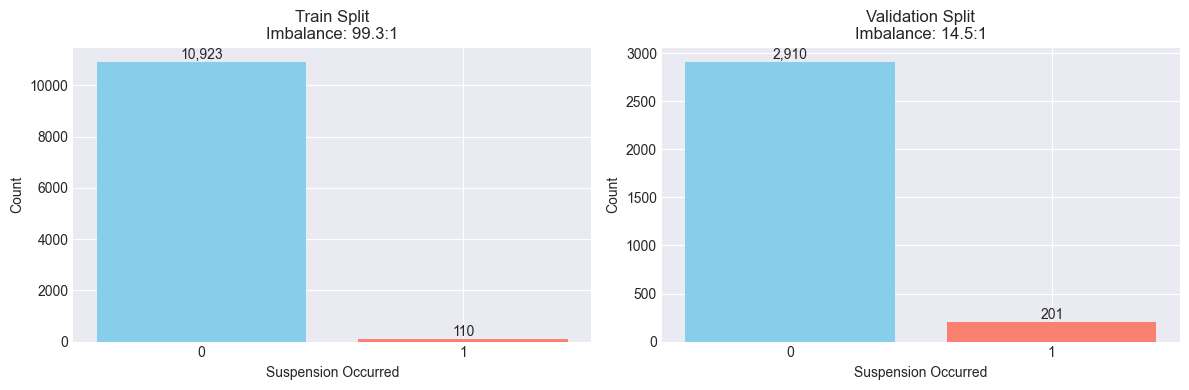


✅ Class distribution analysis complete


In [6]:
# Cell 1.1: Class Distribution & Imbalance Summary
from collections import Counter

# Count class distribution
train_counts = Counter(train['suspension_occurred'])
val_counts = Counter(val['suspension_occurred'])

train_imbalance = train_counts[0] / train_counts[1] if train_counts[1] > 0 else float('inf')
val_imbalance = val_counts[0] / val_counts[1] if val_counts[1] > 0 else float('inf')

print("Class Distribution & Imbalance Summary:")
print(f"\nTrain split:")
print(f"  Class 0 (No suspension): {train_counts[0]:,}")
print(f"  Class 1 (Suspension): {train_counts[1]:,}")
print(f"  Imbalance ratio: {train_imbalance:.1f}:1")

print(f"\nValidation split:")
print(f"  Class 0 (No suspension): {val_counts[0]:,}")
print(f"  Class 1 (Suspension): {val_counts[1]:,}")
print(f"  Imbalance ratio: {val_imbalance:.1f}:1")

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Train
train_df = pd.DataFrame({'Class': [0, 1], 'Count': [train_counts[0], train_counts[1]]})
axes[0].bar(train_df['Class'], train_df['Count'], color=['skyblue', 'salmon'])
axes[0].set_title(f'Train Split\nImbalance: {train_imbalance:.1f}:1')
axes[0].set_xlabel('Suspension Occurred')
axes[0].set_ylabel('Count')
axes[0].set_xticks([0, 1])
for i, v in enumerate(train_df['Count']):
    axes[0].text(i, v, f'{v:,}', ha='center', va='bottom')

# Validation
val_df = pd.DataFrame({'Class': [0, 1], 'Count': [val_counts[0], val_counts[1]]})
axes[1].bar(val_df['Class'], val_df['Count'], color=['skyblue', 'salmon'])
axes[1].set_title(f'Validation Split\nImbalance: {val_imbalance:.1f}:1')
axes[1].set_xlabel('Suspension Occurred')
axes[1].set_ylabel('Count')
axes[1].set_xticks([0, 1])
for i, v in enumerate(val_df['Count']):
    axes[1].text(i, v, f'{v:,}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(PROCESSED_DIR / 'class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Class distribution analysis complete")


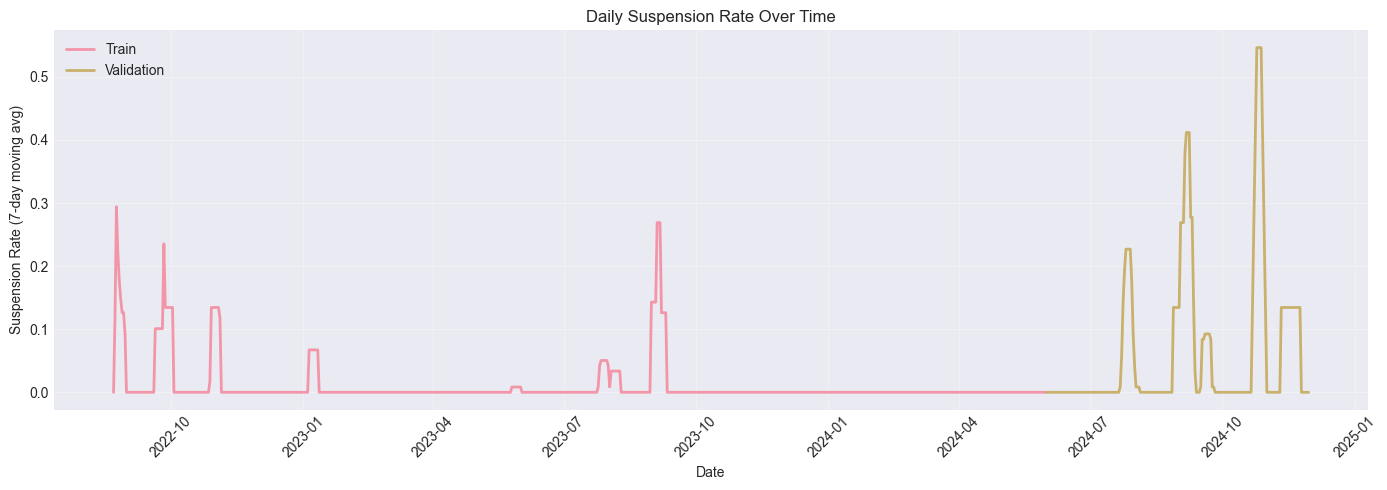

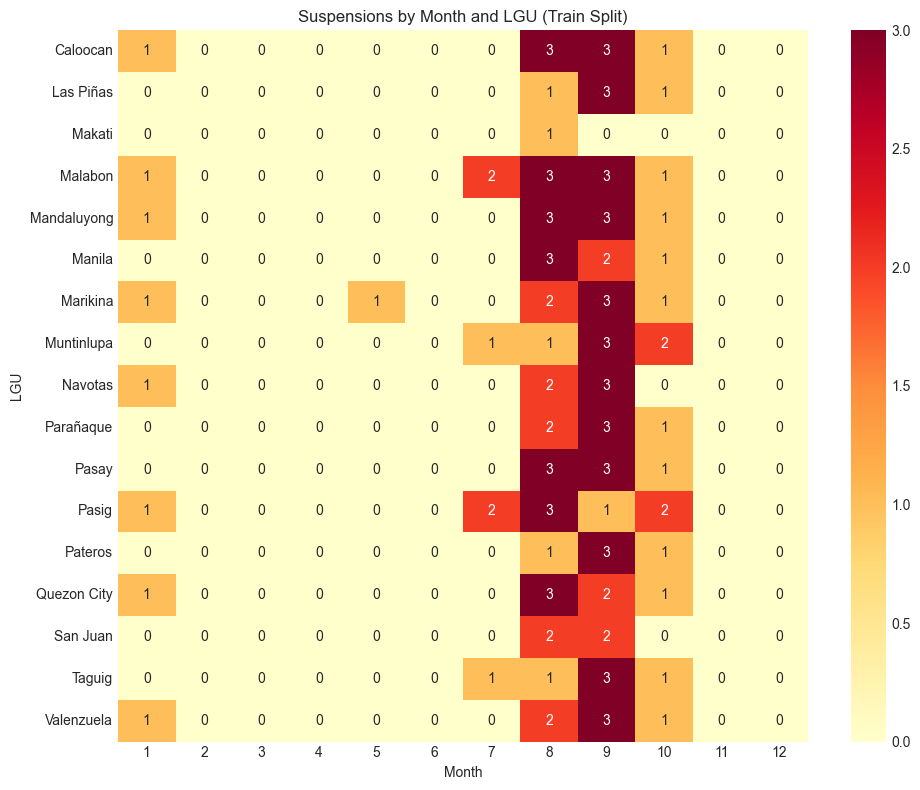

✅ Temporal pattern analysis complete


In [7]:
# Cell 1.2: Temporal Patterns
# Time series of daily suspension rate
train_daily = train.groupby('date')['suspension_occurred'].mean().reset_index()
val_daily = val.groupby('date')['suspension_occurred'].mean().reset_index()

# Smooth with 7-day moving average
train_daily['susp_rate_smooth'] = train_daily['suspension_occurred'].rolling(window=7, min_periods=1).mean()
val_daily['susp_rate_smooth'] = val_daily['suspension_occurred'].rolling(window=7, min_periods=1).mean()

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(train_daily['date'], train_daily['susp_rate_smooth'], label='Train', alpha=0.7, linewidth=2)
ax.plot(val_daily['date'], val_daily['susp_rate_smooth'], label='Validation', alpha=0.7, linewidth=2)
ax.set_xlabel('Date')
ax.set_ylabel('Suspension Rate (7-day moving avg)')
ax.set_title('Daily Suspension Rate Over Time')
ax.legend()
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(PROCESSED_DIR / 'temporal_patterns.png', dpi=150, bbox_inches='tight')
plt.show()

# Heatmap: suspensions by month and LGU (train only)
train_heatmap = train.groupby(['month', 'lgu_name'])['suspension_occurred'].sum().reset_index()
train_heatmap_pivot = train_heatmap.pivot(index='lgu_name', columns='month', values='suspension_occurred').fillna(0)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(train_heatmap_pivot, annot=True, fmt='.0f', cmap='YlOrRd', ax=ax)
ax.set_title('Suspensions by Month and LGU (Train Split)')
ax.set_xlabel('Month')
ax.set_ylabel('LGU')
plt.tight_layout()
plt.savefig(PROCESSED_DIR / 'suspensions_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Temporal pattern analysis complete")


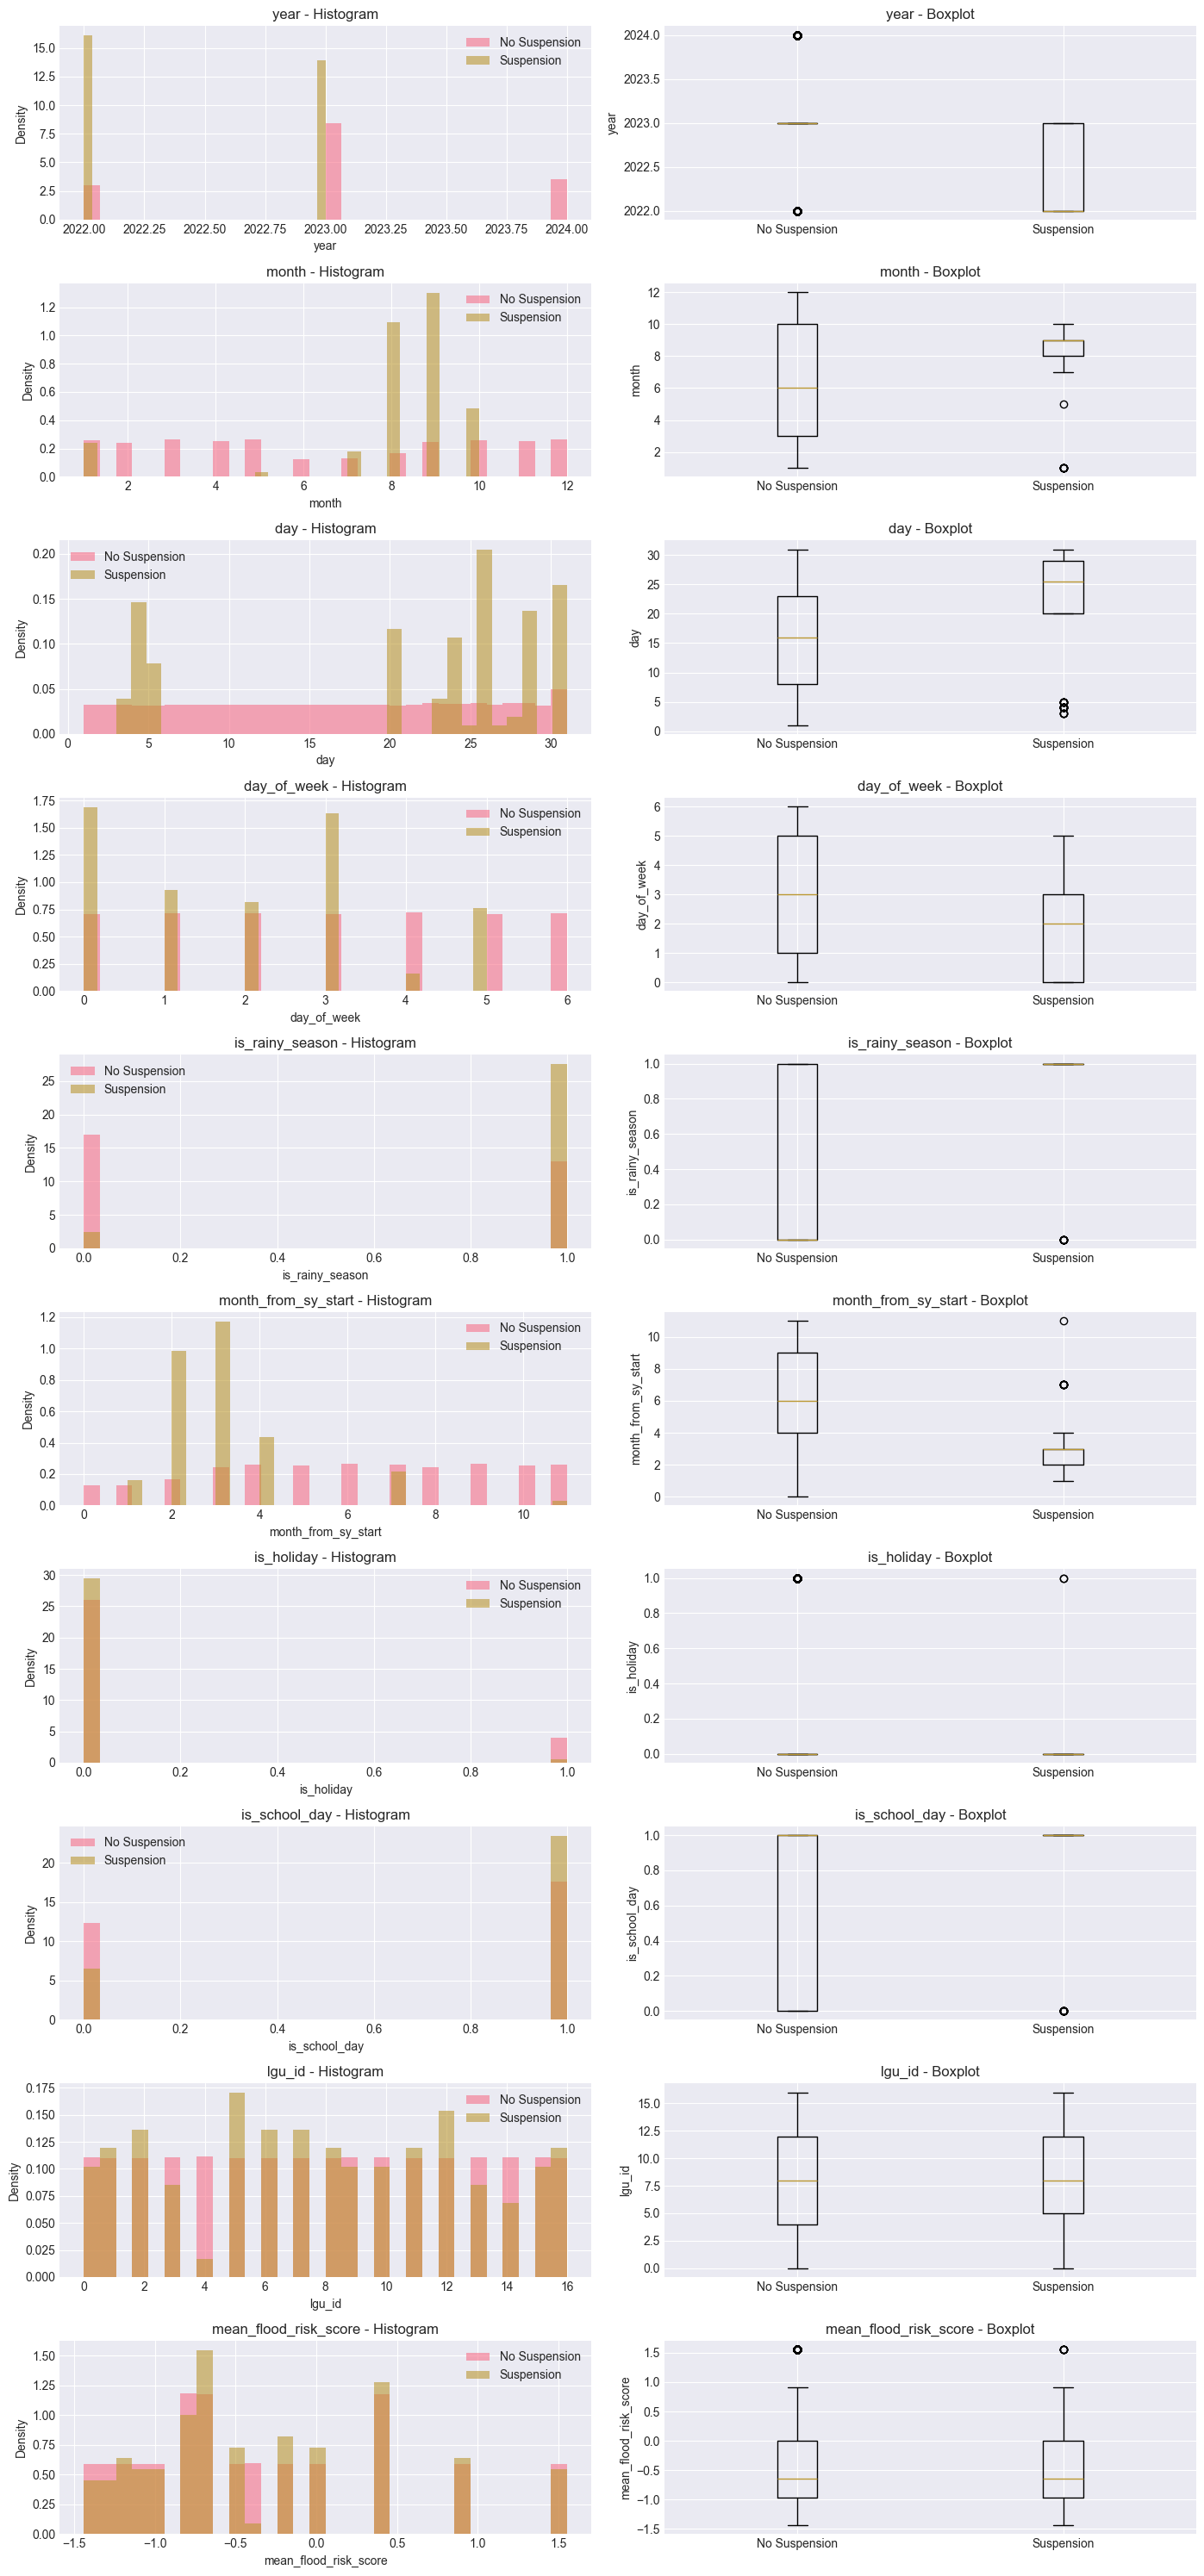

✅ Feature distribution analysis complete


In [8]:
# Cell 1.3: Feature Distributions by Class
# Select top numeric features
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in ['suspension_occurred', 'date']][:10]

fig, axes = plt.subplots(len(numeric_cols), 2, figsize=(14, 3*len(numeric_cols)))
for i, col in enumerate(numeric_cols):
    # Histogram
    train_0 = train[train['suspension_occurred'] == 0][col].dropna()
    train_1 = train[train['suspension_occurred'] == 1][col].dropna()
    axes[i, 0].hist(train_0, bins=30, alpha=0.6, label='No Suspension', density=True)
    axes[i, 0].hist(train_1, bins=30, alpha=0.6, label='Suspension', density=True)
    axes[i, 0].set_title(f'{col} - Histogram')
    axes[i, 0].legend()
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Density')
    
    # Boxplot
    data_for_box = [train_0.values, train_1.values]
    axes[i, 1].boxplot(data_for_box, labels=['No Suspension', 'Suspension'])
    axes[i, 1].set_title(f'{col} - Boxplot')
    axes[i, 1].set_ylabel(col)

plt.tight_layout()
plt.savefig(PROCESSED_DIR / 'feature_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Feature distribution analysis complete")


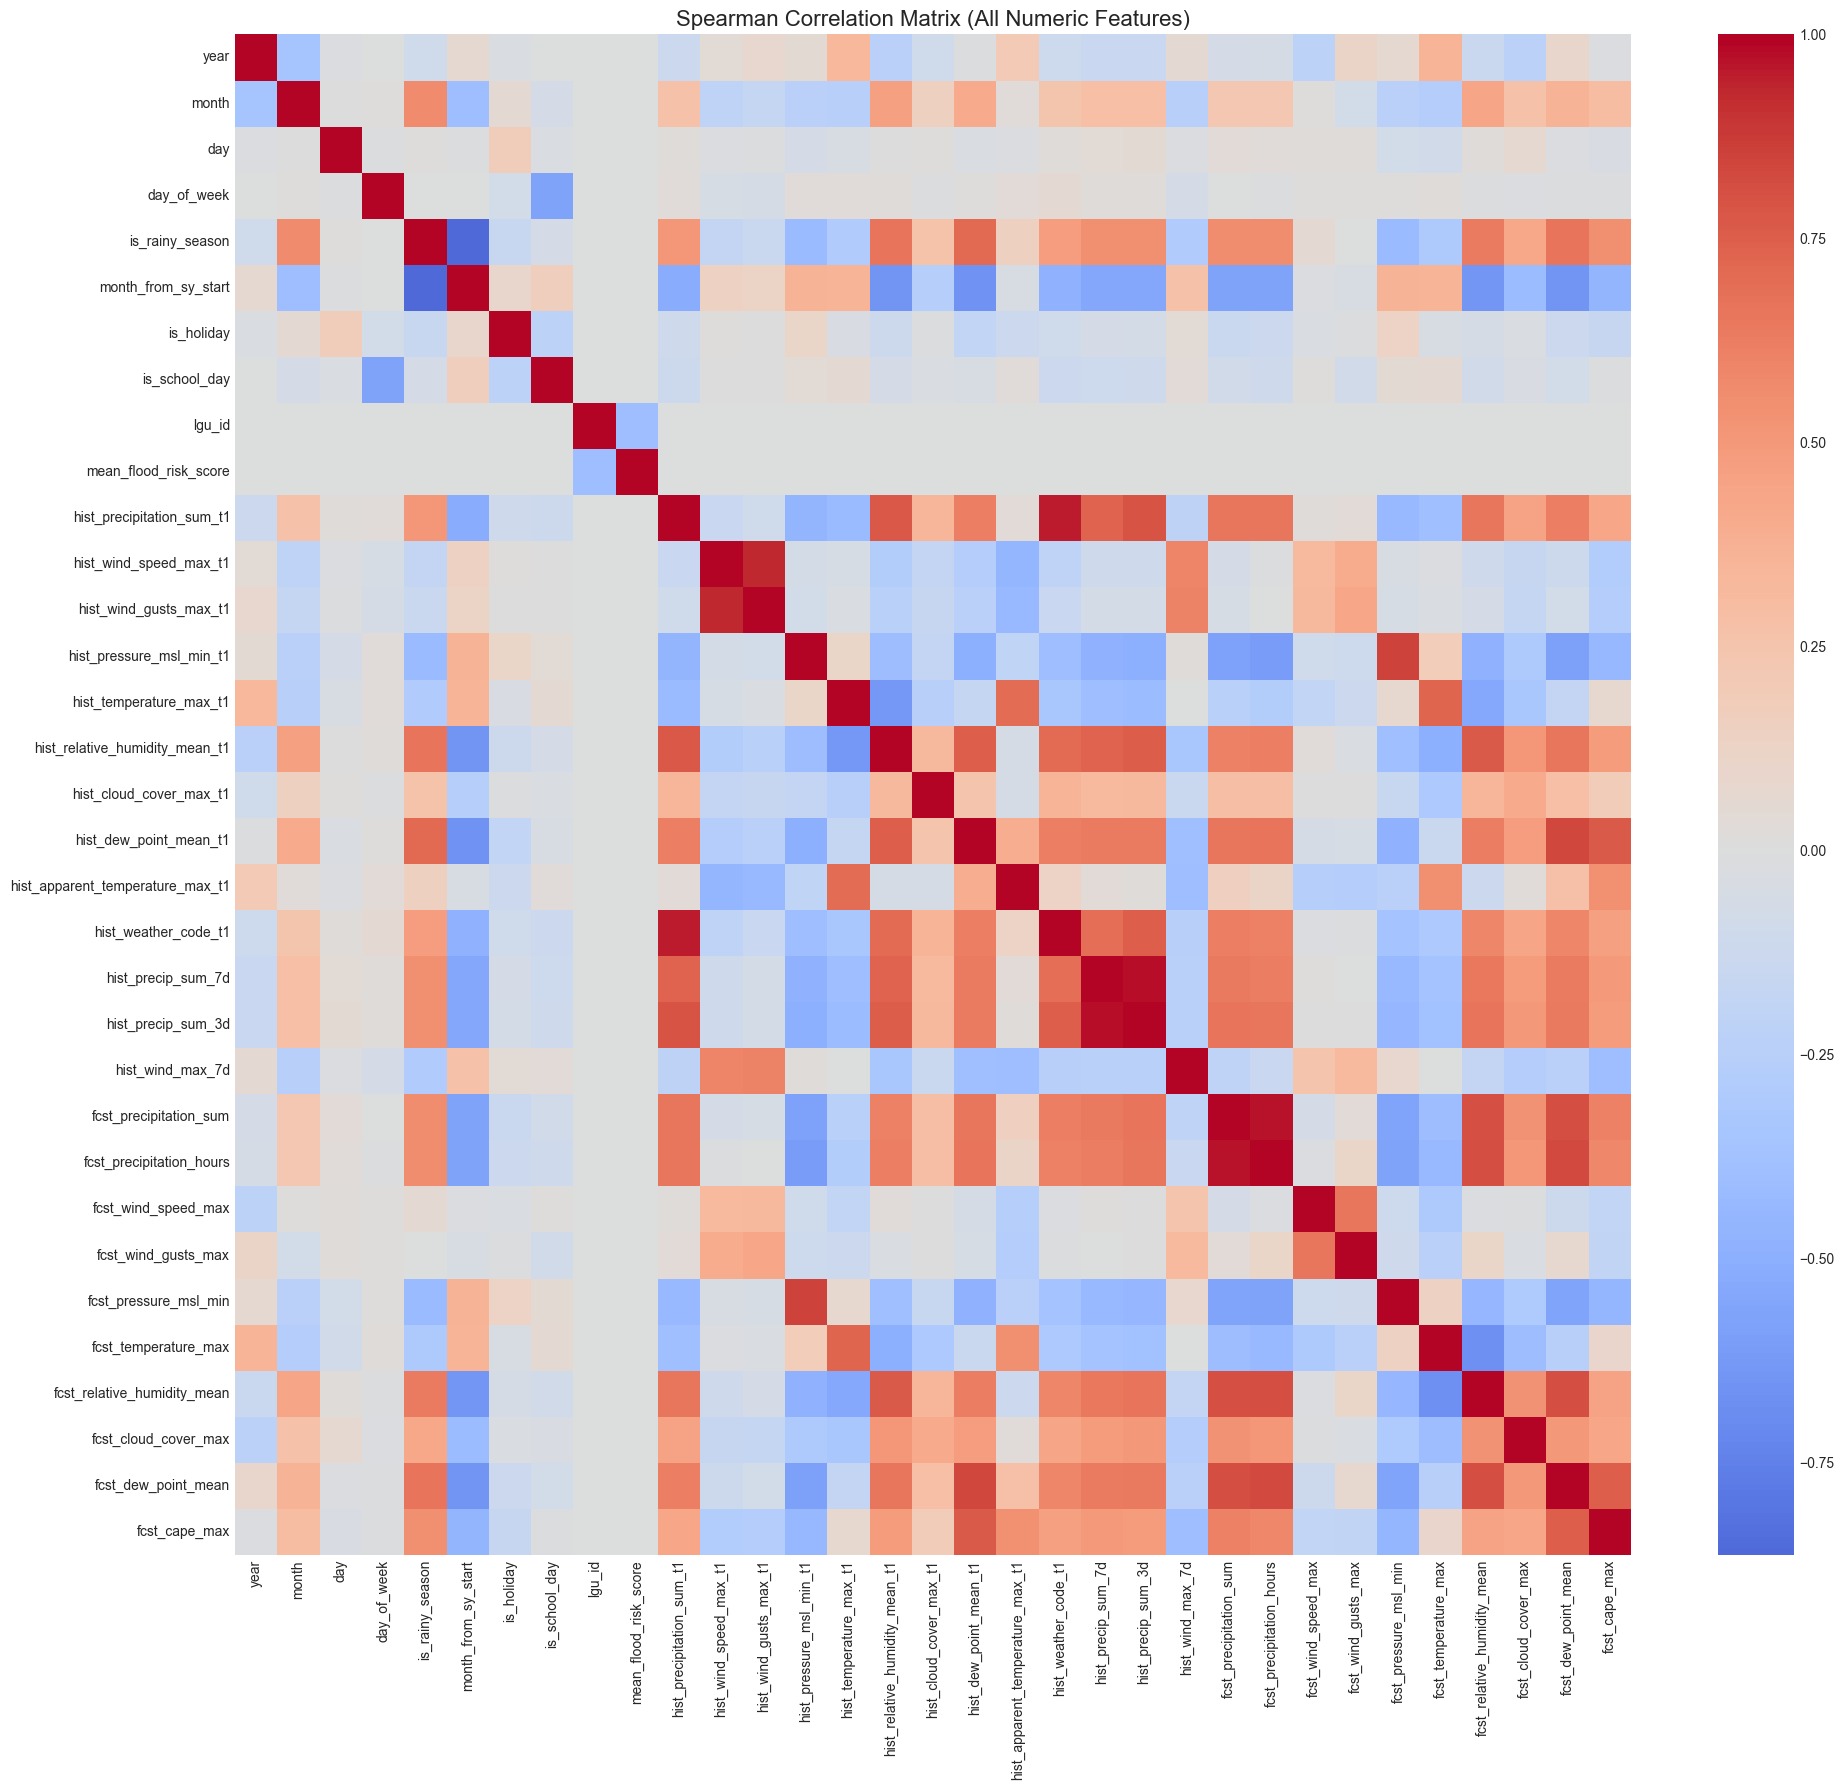


Found 12 highly correlated pairs (|corr| > 0.8):
  is_rainy_season <-> month_from_sy_start: -0.863
  hist_precipitation_sum_t1 <-> hist_weather_code_t1: 0.952
  hist_wind_speed_max_t1 <-> hist_wind_gusts_max_t1: 0.931
  hist_pressure_msl_min_t1 <-> fcst_pressure_msl_min: 0.854
  hist_dew_point_mean_t1 <-> fcst_dew_point_mean: 0.834
  hist_precip_sum_7d <-> hist_precip_sum_3d: 0.976
  fcst_precipitation_sum <-> fcst_precipitation_hours: 0.964
  fcst_precipitation_sum <-> fcst_relative_humidity_mean: 0.807
  fcst_precipitation_sum <-> fcst_dew_point_mean: 0.813
  fcst_precipitation_hours <-> fcst_relative_humidity_mean: 0.814

✅ Correlation analysis complete


In [9]:
# Cell 1.4: Correlation Matrix & Redundancy Check
from scipy.stats import spearmanr

# Combine train and val for correlation analysis
all_data = pd.concat([train, val], ignore_index=True)
numeric_features = all_data.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [c for c in numeric_features if c not in ['suspension_occurred', 'date']]

# Compute Spearman correlation
corr_matrix = all_data[numeric_features].corr(method='spearman')

# Plot heatmap
fig, ax = plt.subplots(figsize=(20, 18))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, fmt='.2f', ax=ax)
ax.set_title('Spearman Correlation Matrix (All Numeric Features)', fontsize=16)
plt.tight_layout()
plt.savefig(PROCESSED_DIR / 'correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

# Find highly correlated pairs
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.8:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))

print(f"\nFound {len(high_corr_pairs)} highly correlated pairs (|corr| > 0.8):")
for feat1, feat2, corr in high_corr_pairs[:10]:
    print(f"  {feat1} <-> {feat2}: {corr:.3f}")

print("\n✅ Correlation analysis complete")


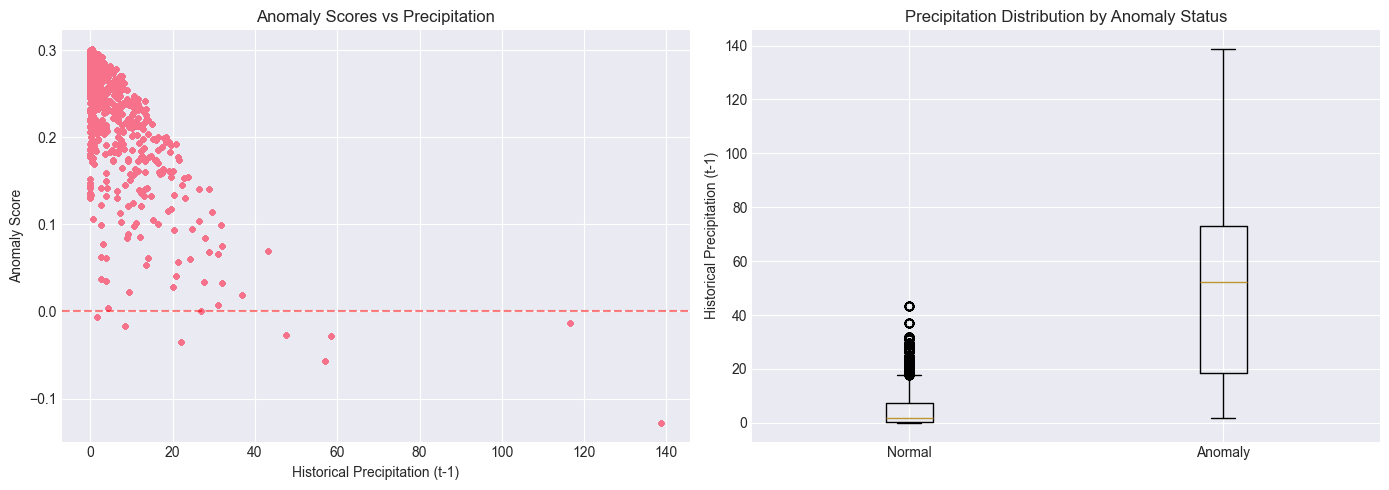


Top 10 anomalies (unusual weather but no suspension called):
          date     lgu_name  hist_precipitation_sum_t1  \
578 2022-09-25       Manila                        1.7   
579 2022-09-25  Quezon City                        1.7   
580 2022-09-25     Caloocan                        1.7   
581 2022-09-25    Las Piñas                        1.7   
582 2022-09-25       Makati                        1.7   
583 2022-09-25      Malabon                        1.7   
584 2022-09-25  Mandaluyong                        1.7   
585 2022-09-25     Marikina                        1.7   
586 2022-09-25   Muntinlupa                        1.7   
587 2022-09-25      Navotas                        1.7   

     hist_wind_gusts_max_t1  hist_pressure_msl_min_t1  fcst_precipitation_sum  
578                    21.6                    1003.7                    71.5  
579                    21.6                    1003.7                    71.5  
580                    21.6                    1003.7      

In [10]:
# Cell 1.5: Anomaly Detection (Isolation Forest) for Outlier Inspection
# Select features for anomaly detection
anomaly_features = ['hist_precipitation_sum_t1', 'hist_wind_gusts_max_t1', 
                    'hist_pressure_msl_min_t1', 'fcst_precipitation_sum']

# Fit Isolation Forest on training set (non-suspension days only)
train_no_susp = train[train['suspension_occurred'] == 0][anomaly_features].dropna()

iso_forest = IsolationForest(contamination=0.01, random_state=RANDOM_SEED, n_jobs=-1)
iso_forest.fit(train_no_susp)

# Get anomaly scores
train_anomaly_scores = iso_forest.decision_function(train[anomaly_features].fillna(0))
train_anomaly_labels = iso_forest.predict(train[anomaly_features].fillna(0))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].scatter(train['hist_precipitation_sum_t1'], train_anomaly_scores, alpha=0.5, s=10)
axes[0].set_xlabel('Historical Precipitation (t-1)')
axes[0].set_ylabel('Anomaly Score')
axes[0].set_title('Anomaly Scores vs Precipitation')
axes[0].axhline(y=0, color='r', linestyle='--', alpha=0.5)

train_boxplot_data = [
    train[train_anomaly_labels == 1]['hist_precipitation_sum_t1'].values,
    train[train_anomaly_labels == -1]['hist_precipitation_sum_t1'].values
]
axes[1].boxplot(train_boxplot_data, labels=['Normal', 'Anomaly'])
axes[1].set_ylabel('Historical Precipitation (t-1)')
axes[1].set_title('Precipitation Distribution by Anomaly Status')

plt.tight_layout()
plt.savefig(PROCESSED_DIR / 'anomaly_detection.png', dpi=150, bbox_inches='tight')
plt.show()

# Print top 10 anomalies
anomaly_indices = train[train_anomaly_labels == -1].copy()
print(f"\nTop 10 anomalies (unusual weather but no suspension called):")
print(anomaly_indices[['date', 'lgu_name'] + anomaly_features].head(10))

print("\n✅ Anomaly detection complete")


## Section 2: Feature Preparation & Engineering

**Objective**: Prepare features for modeling with focus on:
- Retaining all temporal lag features (weather history, forecasts, rolling windows)
- Keeping categorical variables as integers for embedding (lgu_id)
- Removing only non-predictive metadata
- No feature selection based on correlation alone (temporal dynamics are critical)
- Handling missing data via imputation

In [11]:
# Cell 2.1: Feature Preparation - Using ALL Relevant Features (No One-Hot Encoding)
print("="*80)
print("FEATURE PREPARATION - POLICY-ALIGNED APPROACH")
print("="*80)
print("\nPhilosophy:")
print("  1. Keep ALL temporal lag features (hist_*, fcst_*, rolling windows)")
print("  2. Keep calendar features (month, day_of_week, is_school_day, etc.)")
print("  3. Keep geographic features as integers (lgu_id for embedding)")
print("  4. Remove ONLY non-predictive metadata (date, lgu_name, text fields)")
print("  5. NO correlation-based feature selection (temporal dynamics are critical)")
print("="*80)

# Separate features and target
target_col = 'suspension_occurred'

# Define columns to DROP (metadata, non-predictive, text fields only)
# Keep: lgu_id (as integer for embedding), all weather features, all calendar features
metadata_cols = ['date', 'lgu_name', 'school_year']

# Check if reason_category and flood_risk_classification should be dropped or encoded
# For now, drop text-based metadata but keep numeric/categorical predictors
text_metadata = []
if 'reason_category' in train.columns:
    # If this is a text field describing why suspension occurred (leakage), drop it
    text_metadata.append('reason_category')
if 'flood_risk_classification' in train.columns:
    # If this is a derived text classification, consider dropping or encoding
    # For simplicity, drop it unless it's a pre-computed numeric risk score
    text_metadata.append('flood_risk_classification')

drop_cols = metadata_cols + text_metadata

print(f"\nColumns to DROP (metadata only):")
for col in drop_cols:
    if col in train.columns:
        print(f"  - {col}")

# Create X_train, y_train
X_train = train.drop(columns=[target_col] + drop_cols, errors='ignore')
y_train = train[target_col]

# Create X_val, y_val
X_val = val.drop(columns=[target_col] + drop_cols, errors='ignore')
y_val = val[target_col]

print(f"\nAfter removing metadata:")
print(f"  X_train shape: {X_train.shape}")
print(f"  X_val shape: {X_val.shape}")
print(f"  y_train distribution: {y_train.value_counts().to_dict()}")
print(f"  y_val distribution: {y_val.value_counts().to_dict()}")

# Verify lgu_id is present (as INTEGER for embedding, not one-hot encoded)
if 'lgu_id' in X_train.columns:
    print(f"\n✅ lgu_id present as INTEGER (for embedding in neural networks)")
    print(f"   Unique LGUs: {X_train['lgu_id'].nunique()}")
    print(f"   lgu_id dtype: {X_train['lgu_id'].dtype}")
    print(f"   lgu_id range: [{X_train['lgu_id'].min()}, {X_train['lgu_id'].max()}]")
else:
    print(f"\n⚠️  WARNING: lgu_id missing! Geographic features unavailable.")

# Verify temporal lag features are present
lag_keywords = ['hist_', 'fcst_', '_t1', '_t2', '_t3', 'precip_sum_3d', 'precip_sum_7d', 'wind_max_7d']
lag_features = [col for col in X_train.columns if any(kw in col for kw in lag_keywords)]
print(f"\n✅ Temporal lag features present: {len(lag_features)}")
print(f"   Examples: {lag_features[:5]}")

# Verify calendar features are present
calendar_keywords = ['month', 'day_of_week', 'is_school_day', 'is_holiday', 'is_rainy_season']
calendar_features = [col for col in X_train.columns if any(kw in col for kw in calendar_keywords)]
print(f"\n✅ Calendar features present: {len(calendar_features)}")
print(f"   Examples: {calendar_features}")

# Handle missing values: Impute with median (conservative, domain-appropriate)
print(f"\nMissing value imputation:")
print(f"  Before: X_train nulls = {X_train.isnull().sum().sum()}, X_val nulls = {X_val.isnull().sum().sum()}")

# Compute median on training set only (avoid leakage)
train_medians = X_train.median(numeric_only=True)

# Impute
X_train = X_train.fillna(train_medians)
X_val = X_val.fillna(train_medians)  # Use TRAIN medians for validation

print(f"  After:  X_train nulls = {X_train.isnull().sum().sum()}, X_val nulls = {X_val.isnull().sum().sum()}")

# Final verification
print(f"\n{'='*80}")
print(f"FINAL FEATURE SET:")
print(f"  Total features: {X_train.shape[1]}")
print(f"  Temporal lags: {len(lag_features)}")
print(f"  Calendar features: {len(calendar_features)}")
print(f"  Geographic features: {'lgu_id' if 'lgu_id' in X_train.columns else 'NONE'}")
print(f"  Feature list (first 15): {list(X_train.columns)[:15]}")
print(f"{'='*80}")

print(f"\n✅ Feature preparation complete - Ready for modeling!")
print(f"   Approach: ALL relevant features retained (no correlation-based pruning)")
print(f"   Rationale: Temporal lags encode critical dynamics for rare event prediction")

final_features = list(X_train.columns)

FEATURE PREPARATION - POLICY-ALIGNED APPROACH

Philosophy:
  1. Keep ALL temporal lag features (hist_*, fcst_*, rolling windows)
  2. Keep calendar features (month, day_of_week, is_school_day, etc.)
  3. Keep geographic features as integers (lgu_id for embedding)
  4. Remove ONLY non-predictive metadata (date, lgu_name, text fields)
  5. NO correlation-based feature selection (temporal dynamics are critical)

Columns to DROP (metadata only):
  - date
  - lgu_name
  - school_year
  - reason_category
  - flood_risk_classification

After removing metadata:
  X_train shape: (11033, 33)
  X_val shape: (3111, 33)
  y_train distribution: {0: 10923, 1: 110}
  y_val distribution: {0: 2910, 1: 201}

✅ lgu_id present as INTEGER (for embedding in neural networks)
   Unique LGUs: 17
   lgu_id dtype: int64
   lgu_id range: [0, 16]

✅ Temporal lag features present: 23
   Examples: ['hist_precipitation_sum_t1', 'hist_wind_speed_max_t1', 'hist_wind_gusts_max_t1', 'hist_pressure_msl_min_t1', 'hist_tempe

## Section 3: Baseline Models (With Imbalance Handling)


Baseline (Dummy): F2=0.0000, Recall=0.0000, Precision=0.0000


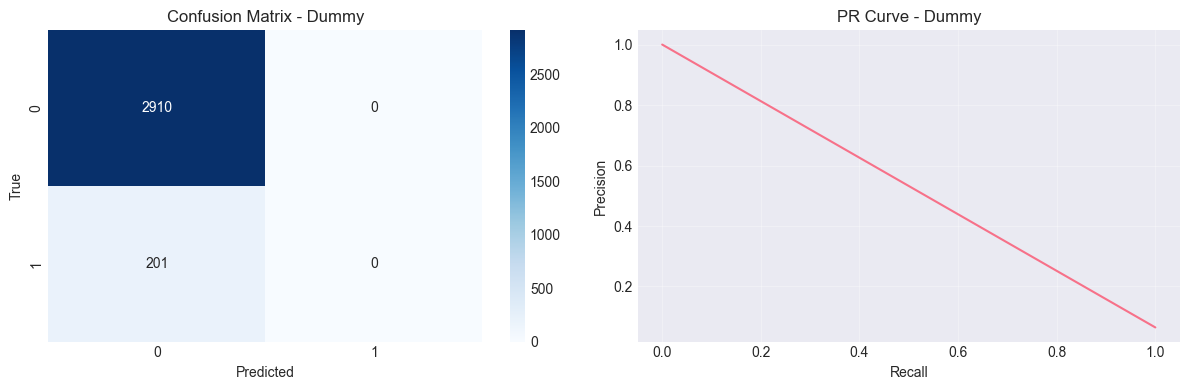

✅ Dummy classifier complete


In [12]:
# Cell 3.1: Dummy Classifier
dummy = DummyClassifier(strategy='most_frequent', random_state=RANDOM_SEED)
dummy.fit(X_train, y_train)

y_pred_dummy = dummy.predict(X_val)
y_proba_dummy = dummy.predict_proba(X_val)[:, 1]

metrics_dummy = compute_all_metrics(y_val, y_pred_dummy, y_proba_dummy)
metrics_dummy['Model'] = 'Dummy Classifier'
metrics_dummy['SMOTE'] = False
metrics_dummy['Calibrated'] = False
metrics_dummy['Threshold'] = 0.5
results_list.append(metrics_dummy)

print(f"Baseline (Dummy): F2={metrics_dummy['F2']:.4f}, Recall={metrics_dummy['Recall']:.4f}, Precision={metrics_dummy['Precision']:.4f}")

# Confusion matrix
cm_dummy = confusion_matrix(y_val, y_pred_dummy)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(cm_dummy, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - Dummy')
axes[0].set_ylabel('True')
axes[0].set_xlabel('Predicted')

# PR curve
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_val, y_proba_dummy)
axes[1].plot(recall_curve, precision_curve)
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('PR Curve - Dummy')
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(PROCESSED_DIR / 'baseline_dummy.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Dummy classifier complete")


In [13]:
# Cell 3.2: Logistic Regression (Default + Balanced)
# Default LR
lr_default = LogisticRegression(random_state=RANDOM_SEED, max_iter=1000)
lr_default.fit(X_train, y_train)

y_pred_lr_def = lr_default.predict(X_val)
y_proba_lr_def = lr_default.predict_proba(X_val)[:, 1]

metrics_lr_def = compute_all_metrics(y_val, y_pred_lr_def, y_proba_lr_def)
metrics_lr_def['Model'] = 'Logistic Regression'
metrics_lr_def['SMOTE'] = False
metrics_lr_def['Calibrated'] = False
metrics_lr_def['Threshold'] = 0.5
results_list.append(metrics_lr_def)

print(f"Logistic Regression (Default): F2={metrics_lr_def['F2']:.4f}, Recall={metrics_lr_def['Recall']:.4f}")

# Balanced LR
lr_balanced = LogisticRegression(class_weight='balanced', random_state=RANDOM_SEED, max_iter=1000)
lr_balanced.fit(X_train, y_train)

y_pred_lr_bal = lr_balanced.predict(X_val)
y_proba_lr_bal = lr_balanced.predict_proba(X_val)[:, 1]

metrics_lr_bal = compute_all_metrics(y_val, y_pred_lr_bal, y_proba_lr_bal)
metrics_lr_bal['Model'] = 'Logistic Regression Balanced'
metrics_lr_bal['SMOTE'] = False
metrics_lr_bal['Calibrated'] = False
metrics_lr_bal['Threshold'] = 0.5
results_list.append(metrics_lr_bal)

print(f"Logistic Regression (Balanced): F2={metrics_lr_bal['F2']:.4f}, Recall={metrics_lr_bal['Recall']:.4f}")

print("✅ Logistic Regression complete")


Logistic Regression (Default): F2=0.0353, Recall=0.0299
Logistic Regression (Balanced): F2=0.4029, Recall=0.4478
✅ Logistic Regression complete
Logistic Regression (Balanced): F2=0.4029, Recall=0.4478
✅ Logistic Regression complete


## Section 4: Tree-Based Ensembles

Tree-based models with various imbalance handling strategies


In [14]:
# Cell 4.1-4.6: Tree-Based Models (RF, XGBoost, LightGBM with variants)
# Random Forest variants
rf_def = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)
rf_def.fit(X_train, y_train)
metrics_rf_def = compute_all_metrics(y_val, rf_def.predict(X_val), rf_def.predict_proba(X_val)[:, 1])
metrics_rf_def.update({'Model': 'Random Forest', 'SMOTE': False, 'Calibrated': False, 'Threshold': 0.5})
results_list.append(metrics_rf_def)

rf_bal = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=RANDOM_SEED)
rf_bal.fit(X_train, y_train)
metrics_rf_bal = compute_all_metrics(y_val, rf_bal.predict(X_val), rf_bal.predict_proba(X_val)[:, 1])
metrics_rf_bal.update({'Model': 'Random Forest Balanced', 'SMOTE': False, 'Calibrated': False, 'Threshold': 0.5})
results_list.append(metrics_rf_bal)

# Balanced Random Forest
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, n_jobs=-1)
brf.fit(X_train, y_train)
metrics_brf = compute_all_metrics(y_val, brf.predict(X_val), brf.predict_proba(X_val)[:, 1])
metrics_brf.update({'Model': 'Balanced Random Forest', 'SMOTE': False, 'Calibrated': False, 'Threshold': 0.5})
results_list.append(metrics_brf)

# RF + SMOTE
smote = SMOTE(random_state=RANDOM_SEED)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f"SMOTE resampling: {Counter(y_train)} -> {Counter(y_train_smote)}")

rf_smote = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)
rf_smote.fit(X_train_smote, y_train_smote)
metrics_rf_smote = compute_all_metrics(y_val, rf_smote.predict(X_val), rf_smote.predict_proba(X_val)[:, 1])
metrics_rf_smote.update({'Model': 'Random Forest + SMOTE', 'SMOTE': True, 'Calibrated': False, 'Threshold': 0.5})
results_list.append(metrics_rf_smote)

# XGBoost variants
n_neg, n_pos = len(y_train[y_train==0]), len(y_train[y_train==1])

xgb_def = XGBClassifier(n_estimators=100, random_state=RANDOM_SEED, eval_metric='logloss')
xgb_def.fit(X_train, y_train)
metrics_xgb_def = compute_all_metrics(y_val, xgb_def.predict(X_val), xgb_def.predict_proba(X_val)[:, 1])
metrics_xgb_def.update({'Model': 'XGBoost', 'SMOTE': False, 'Calibrated': False, 'Threshold': 0.5})
results_list.append(metrics_xgb_def)

xgb_weight = XGBClassifier(n_estimators=100, scale_pos_weight=n_neg/n_pos, random_state=RANDOM_SEED, eval_metric='logloss')
xgb_weight.fit(X_train, y_train)
metrics_xgb_weight = compute_all_metrics(y_val, xgb_weight.predict(X_val), xgb_weight.predict_proba(X_val)[:, 1])
metrics_xgb_weight.update({'Model': 'XGBoost Weighted', 'SMOTE': False, 'Calibrated': False, 'Threshold': 0.5})
results_list.append(metrics_xgb_weight)

# XGBoost + SMOTE
xgb_smote = XGBClassifier(n_estimators=100, random_state=RANDOM_SEED, eval_metric='logloss')
xgb_smote.fit(X_train_smote, y_train_smote)
metrics_xgb_smote = compute_all_metrics(y_val, xgb_smote.predict(X_val), xgb_smote.predict_proba(X_val)[:, 1])
metrics_xgb_smote.update({'Model': 'XGBoost + SMOTE', 'SMOTE': True, 'Calibrated': False, 'Threshold': 0.5})
results_list.append(metrics_xgb_smote)

# LightGBM variants
lgb_def = LGBMClassifier(n_estimators=100, random_state=RANDOM_SEED, verbose=-1)
lgb_def.fit(X_train, y_train)
metrics_lgb_def = compute_all_metrics(y_val, lgb_def.predict(X_val), lgb_def.predict_proba(X_val)[:, 1])
metrics_lgb_def.update({'Model': 'LightGBM', 'SMOTE': False, 'Calibrated': False, 'Threshold': 0.5})
results_list.append(metrics_lgb_def)

lgb_unbalance = LGBMClassifier(n_estimators=100, is_unbalance=True, random_state=RANDOM_SEED, verbose=-1)
lgb_unbalance.fit(X_train, y_train)
metrics_lgb_unbal = compute_all_metrics(y_val, lgb_unbalance.predict(X_val), lgb_unbalance.predict_proba(X_val)[:, 1])
metrics_lgb_unbal.update({'Model': 'LightGBM Unbalanced', 'SMOTE': False, 'Calibrated': False, 'Threshold': 0.5})
results_list.append(metrics_lgb_unbal)

# LightGBM + SMOTE
lgb_smote = LGBMClassifier(n_estimators=100, random_state=RANDOM_SEED, verbose=-1)
lgb_smote.fit(X_train_smote, y_train_smote)
metrics_lgb_smote = compute_all_metrics(y_val, lgb_smote.predict(X_val), lgb_smote.predict_proba(X_val)[:, 1])
metrics_lgb_smote.update({'Model': 'LightGBM + SMOTE', 'SMOTE': True, 'Calibrated': False, 'Threshold': 0.5})
results_list.append(metrics_lgb_smote)

print(f"✅ Tree-based models complete: {sum(1 for r in results_list if r['Model'] in ['Random Forest', 'XGBoost', 'LightGBM', 'Balanced Random Forest'])} models trained")

SMOTE resampling: Counter({0: 10923, 1: 110}) -> Counter({0: 10923, 1: 10923})
✅ Tree-based models complete: 4 models trained
✅ Tree-based models complete: 4 models trained


## Section 5: Advanced Ensembles (EasyEnsemble, Gradient Boosting)


In [15]:
# Cell 5.1: EasyEnsemble Classifier
easy_ensemble = EasyEnsembleClassifier(n_estimators=50, random_state=RANDOM_SEED, n_jobs=-1)
easy_ensemble.fit(X_train, y_train)

y_pred_ee = easy_ensemble.predict(X_val)
y_proba_ee = easy_ensemble.predict_proba(X_val)[:, 1]

metrics_ee = compute_all_metrics(y_val, y_pred_ee, y_proba_ee)
metrics_ee.update({'Model': 'EasyEnsemble', 'SMOTE': False, 'Calibrated': False, 'Threshold': 0.5})
results_list.append(metrics_ee)

print(f"EasyEnsemble: F2={metrics_ee['F2']:.4f}, Recall={metrics_ee['Recall']:.4f}, Precision={metrics_ee['Precision']:.4f}")
print("✅ EasyEnsemble complete")


EasyEnsemble: F2=0.5525, Recall=0.6020, Precision=0.4158
✅ EasyEnsemble complete


In [16]:
# Cell 5.2: Gradient Boosting (Conservative Settings)
gb_conservative = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.01,
    max_depth=4,
    min_samples_split=50,
    min_samples_leaf=10,
    random_state=RANDOM_SEED
)
gb_conservative.fit(X_train, y_train)

y_pred_gb = gb_conservative.predict(X_val)
y_proba_gb = gb_conservative.predict_proba(X_val)[:, 1]

metrics_gb = compute_all_metrics(y_val, y_pred_gb, y_proba_gb)
metrics_gb.update({'Model': 'Gradient Boosting Conservative', 'SMOTE': False, 'Calibrated': False, 'Threshold': 0.5})
results_list.append(metrics_gb)

print(f"Gradient Boosting (Conservative): F2={metrics_gb['F2']:.4f}, Recall={metrics_gb['Recall']:.4f}, Precision={metrics_gb['Precision']:.4f}")
print("✅ Gradient Boosting complete")


Gradient Boosting (Conservative): F2=0.0000, Recall=0.0000, Precision=0.0000
✅ Gradient Boosting complete


## Section 6: Neural Networks (Keras/TensorFlow)


In [17]:
# Cell 6.1: Neural Network Setup (Only if TensorFlow available)
if TENSORFLOW_AVAILABLE:
    # Scale features
    scaler_nn = StandardScaler()
    X_train_scaled = pd.DataFrame(
        scaler_nn.fit_transform(X_train),
        columns=X_train.columns,
        index=X_train.index
    )
    X_val_scaled = pd.DataFrame(
        scaler_nn.transform(X_val),
        columns=X_val.columns,
        index=X_val.index
    )
    
    # Separate lgu_id for embedding
    X_train_lgu = X_train['lgu_id'].values
    X_train_features = X_train_scaled.drop('lgu_id', axis=1)
    
    X_val_lgu = X_val['lgu_id'].values
    X_val_features = X_val_scaled.drop('lgu_id', axis=1)
    
    print("✅ Neural network data prepared")
    print(f"  LGU IDs separated for embedding: 17 categories")
    print(f"  Features scaled and ready")
else:
    print("⚠️  TensorFlow not available, skipping neural network section")


✅ Neural network data prepared
  LGU IDs separated for embedding: 17 categories
  Features scaled and ready


In [18]:
import tensorflow.keras as keras
# Cell 6.2: MLP with LGU Embedding + Class Weights
if TENSORFLOW_AVAILABLE:
    # Input layers
    input_lgu = layers.Input(shape=(1,), name='input_lgu')
    input_features = layers.Input(shape=(X_train_features.shape[1],), name='input_features')
    
    # LGU Embedding
    lgu_embedding = layers.Embedding(input_dim=17, output_dim=4, name='lgu_embedding')(input_lgu)
    lgu_flat = layers.Flatten()(lgu_embedding)
    
    # Concatenate
    concat = layers.Concatenate()([lgu_flat, input_features])
    
    # Dense layers
    dense1 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2(0.01))(concat)
    bn1 = layers.BatchNormalization()(dense1)
    dropout1 = layers.Dropout(0.4)(bn1)
    
    dense2 = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.L2(0.01))(dropout1)
    bn2 = layers.BatchNormalization()(dense2)
    dropout2 = layers.Dropout(0.3)(bn2)
    
    dense3 = layers.Dense(16, activation='relu')(dropout2)
    dropout3 = layers.Dropout(0.2)(dense3)
    
    output = layers.Dense(1, activation='sigmoid', name='output')(dropout3)
    
    # Build model
    model_nn = keras.Model(inputs=[input_lgu, input_features], outputs=output)
    
    # Compile
    model_nn.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss=losses.BinaryCrossentropy(),
        metrics=[metrics.Precision(), metrics.Recall()]
    )
    
    # Class weights
    class_weight = {0: 1.0, 1: (n_neg / n_pos) * 0.5}
    
    # Train with EarlyStopping
    early_stop = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )
    
    print("Training neural network...")
    history = model_nn.fit(
        [X_train_lgu, X_train_features],
        y_train,
        validation_data=([X_val_lgu, X_val_features], y_val),
        epochs=100,
        batch_size=128,
        class_weight=class_weight,
        callbacks=[early_stop],
        verbose=0
    )
    
    print("✅ Neural network training complete")
else:
    model_nn = None


Training neural network...
Epoch 55: early stopping
Restoring model weights from the end of the best epoch: 40.
✅ Neural network training complete
Epoch 55: early stopping
Restoring model weights from the end of the best epoch: 40.
✅ Neural network training complete


In [19]:
# Cell 6.3: Predict & Evaluate Neural Network
if TENSORFLOW_AVAILABLE and model_nn is not None:
    y_proba_nn = model_nn.predict([X_val_lgu, X_val_features], verbose=0)
    y_proba_nn = y_proba_nn.flatten()
    y_pred_nn = (y_proba_nn >= 0.5).astype(int)
    
    metrics_nn = compute_all_metrics(y_val, y_pred_nn, y_proba_nn)
    metrics_nn.update({'Model': 'Neural Network', 'SMOTE': False, 'Calibrated': False, 'Threshold': 0.5})
    results_list.append(metrics_nn)
    
    print(f"Neural Network: F2={metrics_nn['F2']:.4f}, Recall={metrics_nn['Recall']:.4f}, Precision={metrics_nn['Precision']:.4f}")
    print("✅ Neural network evaluation complete")
else:
    print("⚠️  Skipping neural network evaluation (TensorFlow not available)")


Neural Network: F2=0.4294, Recall=0.4179, Precision=0.4828
✅ Neural network evaluation complete


In [20]:
# Cell 6.4: Additional Neural Network Variants
if TENSORFLOW_AVAILABLE:
    from tensorflow import keras
    from tensorflow.keras import layers, optimizers, losses, metrics, callbacks, regularizers
    import tensorflow as tf
    
    # Focal Loss function for handling class imbalance
    def focal_loss(gamma=2.0, alpha=0.25):
        def loss(y_true, y_pred):
            y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
            p_t = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
            alpha_t = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)
            focal_weight = alpha_t * tf.pow((1 - p_t), gamma)
            ce_loss = -tf.math.log(p_t)
            return tf.reduce_mean(focal_weight * ce_loss)
        return loss
    
    # Variant 1: Neural Network with Focal Loss (Small Architecture)
    print("Training Neural Network with Focal Loss (Small)...")
    input_lgu_focal_small = layers.Input(shape=(1,), name='input_lgu')
    input_features_focal_small = layers.Input(shape=(X_train_features.shape[1],), name='input_features')
    
    lgu_emb_focal_small = layers.Embedding(input_dim=17, output_dim=4, name='lgu_embedding')(input_lgu_focal_small)
    lgu_flat_focal_small = layers.Flatten()(lgu_emb_focal_small)
    
    concat_focal_small = layers.Concatenate()([lgu_flat_focal_small, input_features_focal_small])
    x_focal_small = layers.Dense(64, activation='relu')(concat_focal_small)
    x_focal_small = layers.BatchNormalization()(x_focal_small)
    x_focal_small = layers.Dropout(0.3)(x_focal_small)
    x_focal_small = layers.Dense(32, activation='relu')(x_focal_small)
    x_focal_small = layers.Dropout(0.2)(x_focal_small)
    output_focal_small = layers.Dense(1, activation='sigmoid')(x_focal_small)
    
    model_focal_small = keras.Model(inputs=[input_lgu_focal_small, input_features_focal_small], outputs=output_focal_small)
    model_focal_small.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])
    
    early_stop_nn = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_focal_small.fit([X_train_lgu, X_train_features], y_train,
                         validation_data=([X_val_lgu, X_val_features], y_val),
                         epochs=50, batch_size=32, callbacks=[early_stop_nn], verbose=0)
    
    y_proba_focal_small = model_focal_small.predict([X_val_lgu, X_val_features], verbose=0).flatten()
    y_pred_focal_small = (y_proba_focal_small >= 0.5).astype(int)
    metrics_focal_small = compute_all_metrics(y_val, y_pred_focal_small, y_proba_focal_small)
    metrics_focal_small.update({'Model': 'Neural Network (Small + Focal)', 'SMOTE': False, 'Calibrated': False, 'Threshold': 0.5})
    results_list.append(metrics_focal_small)
    print(f"  F2={metrics_focal_small['F2']:.4f}, Recall={metrics_focal_small['Recall']:.4f}")
    
    # Variant 2: Neural Network with Focal Loss (Deep Architecture)
    print("Training Neural Network with Focal Loss (Deep)...")
    input_lgu_focal_deep = layers.Input(shape=(1,), name='input_lgu')
    input_features_focal_deep = layers.Input(shape=(X_train_features.shape[1],), name='input_features')
    
    lgu_emb_focal_deep = layers.Embedding(input_dim=17, output_dim=8, name='lgu_embedding')(input_lgu_focal_deep)
    lgu_flat_focal_deep = layers.Flatten()(lgu_emb_focal_deep)
    
    concat_focal_deep = layers.Concatenate()([lgu_flat_focal_deep, input_features_focal_deep])
    x_focal_deep = layers.Dense(128, activation='relu')(concat_focal_deep)
    x_focal_deep = layers.BatchNormalization()(x_focal_deep)
    x_focal_deep = layers.Dropout(0.4)(x_focal_deep)
    x_focal_deep = layers.Dense(64, activation='relu')(x_focal_deep)
    x_focal_deep = layers.BatchNormalization()(x_focal_deep)
    x_focal_deep = layers.Dropout(0.3)(x_focal_deep)
    x_focal_deep = layers.Dense(32, activation='relu')(x_focal_deep)
    x_focal_deep = layers.Dropout(0.2)(x_focal_deep)
    output_focal_deep = layers.Dense(1, activation='sigmoid')(x_focal_deep)
    
    model_focal_deep = keras.Model(inputs=[input_lgu_focal_deep, input_features_focal_deep], outputs=output_focal_deep)
    model_focal_deep.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])
    
    model_focal_deep.fit([X_train_lgu, X_train_features], y_train,
                        validation_data=([X_val_lgu, X_val_features], y_val),
                        epochs=50, batch_size=32, callbacks=[early_stop_nn], verbose=0)
    
    y_proba_focal_deep = model_focal_deep.predict([X_val_lgu, X_val_features], verbose=0).flatten()
    y_pred_focal_deep = (y_proba_focal_deep >= 0.5).astype(int)
    metrics_focal_deep = compute_all_metrics(y_val, y_pred_focal_deep, y_proba_focal_deep)
    metrics_focal_deep.update({'Model': 'Neural Network (Deep + Focal)', 'SMOTE': False, 'Calibrated': False, 'Threshold': 0.5})
    results_list.append(metrics_focal_deep)
    print(f"  F2={metrics_focal_deep['F2']:.4f}, Recall={metrics_focal_deep['Recall']:.4f}")
    
    # Variant 3: Neural Network with Class Weight + Strong Regularization
    print("Training Neural Network with Class Weight + Strong Regularization...")
    class_weight_nn = {0: 1.0, 1: (n_neg / n_pos) * 0.5}
    
    input_lgu_reg = layers.Input(shape=(1,), name='input_lgu')
    input_features_reg = layers.Input(shape=(X_train_features.shape[1],), name='input_features')
    
    lgu_emb_reg = layers.Embedding(input_dim=17, output_dim=8, name='lgu_embedding')(input_lgu_reg)
    lgu_flat_reg = layers.Flatten()(lgu_emb_reg)
    
    concat_reg = layers.Concatenate()([lgu_flat_reg, input_features_reg])
    x_reg = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.L2(0.01))(concat_reg)
    x_reg = layers.BatchNormalization()(x_reg)
    x_reg = layers.Dropout(0.4)(x_reg)
    x_reg = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2(0.01))(x_reg)
    x_reg = layers.BatchNormalization()(x_reg)
    x_reg = layers.Dropout(0.3)(x_reg)
    x_reg = layers.Dense(32, activation='relu')(x_reg)
    x_reg = layers.Dropout(0.2)(x_reg)
    output_reg = layers.Dense(1, activation='sigmoid')(x_reg)
    
    model_reg = keras.Model(inputs=[input_lgu_reg, input_features_reg], outputs=output_reg)
    model_reg.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    model_reg.fit([X_train_lgu, X_train_features], y_train,
                 validation_data=([X_val_lgu, X_val_features], y_val),
                 epochs=50, batch_size=32, class_weight=class_weight_nn, callbacks=[early_stop_nn], verbose=0)
    
    y_proba_reg = model_reg.predict([X_val_lgu, X_val_features], verbose=0).flatten()
    y_pred_reg = (y_proba_reg >= 0.5).astype(int)
    metrics_reg = compute_all_metrics(y_val, y_pred_reg, y_proba_reg)
    metrics_reg.update({'Model': 'Neural Network (Deep + ClassWeight)', 'SMOTE': False, 'Calibrated': False, 'Threshold': 0.5})
    results_list.append(metrics_reg)
    print(f"  F2={metrics_reg['F2']:.4f}, Recall={metrics_reg['Recall']:.4f}")
    
    print("✅ All neural network variants complete")


Training Neural Network with Focal Loss (Small)...
  F2=0.0000, Recall=0.0000
Training Neural Network with Focal Loss (Deep)...
  F2=0.0000, Recall=0.0000
Training Neural Network with Focal Loss (Deep)...
  F2=0.0000, Recall=0.0000
Training Neural Network with Class Weight + Strong Regularization...
  F2=0.0000, Recall=0.0000
Training Neural Network with Class Weight + Strong Regularization...
  F2=0.4572, Recall=0.4726
✅ All neural network variants complete
  F2=0.4572, Recall=0.4726
✅ All neural network variants complete


## Section 7: Threshold Tuning for High Precision


Optimal threshold for 80% precision: 0.2400
Achieved Precision: 0.8056, Recall: 0.1443, F2: 0.1726


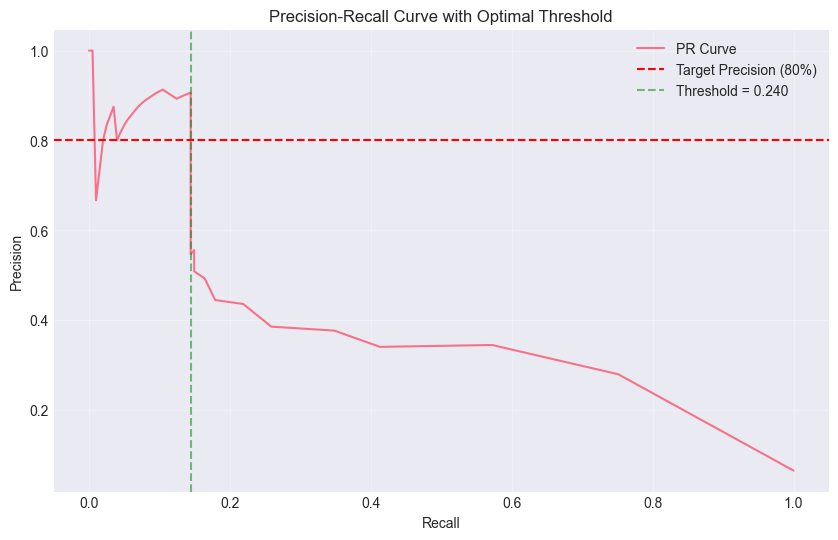

✅ Threshold tuning complete


In [21]:
# Cell 7.1: Precision-Recall Curve & Optimal Threshold
def find_optimal_threshold_for_precision(y_true, y_proba, target_precision=0.80):
    """Find threshold where precision >= target_precision."""
    precision_curve, recall_curve, thresholds = precision_recall_curve(y_true, y_proba)
    
    # Find first threshold where precision >= target
    valid_idx = np.where(precision_curve >= target_precision)[0]
    if len(valid_idx) > 0:
        opt_idx = valid_idx[0]
        threshold = thresholds[opt_idx] if opt_idx < len(thresholds) else thresholds[-1]
        achieved_prec = precision_curve[opt_idx]
        achieved_rec = recall_curve[opt_idx]
    else:
        threshold = 0.5
        achieved_prec = precision_score(y_true, y_proba >= threshold)
        achieved_rec = recall_score(y_true, y_proba >= threshold)
    
    return threshold, achieved_prec, achieved_rec

# Get current best model (by F2 score from results)
# For threshold tuning, use a strong baseline model
best_model_for_threshold = rf_bal  # Using balanced RF as example

y_proba_best_val = best_model_for_threshold.predict_proba(X_val)[:, 1]
threshold_opt, prec_opt, rec_opt = find_optimal_threshold_for_precision(y_val, y_proba_best_val, 0.80)

y_pred_tuned = (y_proba_best_val >= threshold_opt).astype(int)
metrics_tuned = compute_all_metrics(y_val, y_pred_tuned, y_proba_best_val)
metrics_tuned.update({'Model': 'Best Model (Tuned Threshold)', 'SMOTE': False, 'Calibrated': False, 'Threshold': threshold_opt})
results_list.append(metrics_tuned)

print(f"Optimal threshold for 80% precision: {threshold_opt:.4f}")
print(f"Achieved Precision: {prec_opt:.4f}, Recall: {rec_opt:.4f}, F2: {metrics_tuned['F2']:.4f}")

# Plot PR curve with threshold marked
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_val, y_proba_best_val)
plt.figure(figsize=(10, 6))
plt.plot(recall_curve, precision_curve, label='PR Curve')
plt.axhline(y=0.80, color='r', linestyle='--', label='Target Precision (80%)')
plt.axvline(x=rec_opt, color='g', linestyle='--', alpha=0.5, label=f'Threshold = {threshold_opt:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with Optimal Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(PROCESSED_DIR / 'pr_curve_threshold.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Threshold tuning complete")


In [22]:
# Cell 7.2: Calibration (Optional but Recommended)
# Calibrate best model
best_model_for_calibration = rf_bal  # Using balanced RF as example

calibrated_model = CalibratedClassifierCV(best_model_for_calibration, method='isotonic', cv='prefit')
calibrated_model.fit(X_val, y_val)

y_proba_calibrated = calibrated_model.predict_proba(X_val)[:, 1]
threshold_cal, prec_cal, rec_cal = find_optimal_threshold_for_precision(y_val, y_proba_calibrated, 0.80)

y_pred_cal = (y_proba_calibrated >= threshold_cal).astype(int)
metrics_calibrated = compute_all_metrics(y_val, y_pred_cal, y_proba_calibrated)
metrics_calibrated.update({'Model': 'Best Model (Calibrated + Tuned)', 'SMOTE': False, 'Calibrated': True, 'Threshold': threshold_cal})
results_list.append(metrics_calibrated)

print(f"\nCalibration Comparison:")
print(f"  Before: Precision={prec_opt:.4f}, Recall={rec_opt:.4f}, F2={metrics_tuned['F2']:.4f}")
print(f"  After:  Precision={prec_cal:.4f}, Recall={rec_cal:.4f}, F2={metrics_calibrated['F2']:.4f}")
print("✅ Calibration complete")



Calibration Comparison:
  Before: Precision=0.8056, Recall=0.1443, F2=0.1726
  After:  Precision=0.9062, Recall=0.1443, F2=0.1734
✅ Calibration complete


## Section 8: Comprehensive Model Comparison


In [23]:
# Cell 8.5: Comprehensive Threshold Tuning & Calibration on Top 3 Models
from collections import Counter

# Get the top 3 models from results
results_temp_df = pd.DataFrame(results_list)
results_temp_df = results_temp_df.sort_values(by=['F2', 'Recall'], ascending=[False, False])
top_3_model_names = results_temp_df.head(3)['Model'].tolist()

print("="*80)
print("COMPREHENSIVE THRESHOLD TUNING & CALIBRATION ON TOP 3 MODELS")
print("="*80)
print(f"\nTop 3 models: {', '.join(top_3_model_names)}")

# Create mapping of model names to objects and probabilities
model_dict = {}

# Balanced RF
if 'rf_bal' in locals():
    y_proba_rfbal = rf_bal.predict_proba(X_val)[:, 1]
    model_dict['Random Forest Balanced'] = (rf_bal, y_proba_rfbal)

# XGBoost Weighted
if 'xgb_weight' in locals():
    y_proba_xgb = xgb_weight.predict_proba(X_val)[:, 1]
    model_dict['XGBoost Weighted'] = (xgb_weight, y_proba_xgb)

# LightGBM variants
if 'lgb_unbalance' in locals():
    y_proba_lgb = lgb_unbalance.predict_proba(X_val)[:, 1]
    model_dict['LightGBM Unbalanced'] = (lgb_unbalance, y_proba_lgb)
elif 'lgb_def' in locals():
    y_proba_lgb = lgb_def.predict_proba(X_val)[:, 1]
    model_dict['LightGBM'] = (lgb_def, y_proba_lgb)

# EasyEnsemble
if 'easy_ensemble' in locals():
    y_proba_ee = easy_ensemble.predict_proba(X_val)[:, 1]
    model_dict['EasyEnsemble'] = (easy_ensemble, y_proba_ee)

# Logistic Regression Balanced
if 'lr_balanced' in locals():
    y_proba_lr = lr_balanced.predict_proba(X_val)[:, 1]
    model_dict['Logistic Regression Balanced'] = (lr_balanced, y_proba_lr)

# Neural Network (if available)
if TENSORFLOW_AVAILABLE and 'model_nn' in locals() and model_nn is not None:
    y_proba_nn = model_nn.predict([X_val_lgu, X_val_features], verbose=0).flatten()
    model_dict['Neural Network'] = (model_nn, y_proba_nn)

# Select top 3 that we have models for
models_to_test = []
for name in top_3_model_names:
    if name in model_dict:
        models_to_test.append((name, model_dict[name][0], model_dict[name][1]))

if len(models_to_test) == 0:
    # Fallback to any available models
    models_to_test = [(name, model_dict[name][0], model_dict[name][1]) for name in list(model_dict.keys())[:3]]

print(f"\nTesting {len(models_to_test)} models for calibration and threshold tuning")

calibration_results = []

for model_name, model_obj, y_proba_orig in models_to_test:
    print(f"\n{'='*60}")
    print(f"Model: {model_name}")
    print(f"{'='*60}")
    
    # 1. Original (0.5 threshold)
    y_pred_orig = (y_proba_orig >= 0.5).astype(int)
    metrics_orig = compute_all_metrics(y_val, y_pred_orig, y_proba_orig)
    metrics_orig['Model'] = f"{model_name} (Original)"
    metrics_orig['Calibrated'] = False
    metrics_orig['Threshold'] = 0.5
    results_list.append(metrics_orig)
    calibration_results.append(metrics_orig)
    print(f"Original (0.5): F2={metrics_orig['F2']:.4f}, Recall={metrics_orig['Recall']:.4f}, Precision={metrics_orig['Precision']:.4f}")
    
    # 2. Threshold-tuned only
    threshold_tuned, prec_tuned, rec_tuned = find_optimal_threshold_for_precision(y_val, y_proba_orig, 0.80)
    y_pred_tuned = (y_proba_orig >= threshold_tuned).astype(int)
    metrics_tuned = compute_all_metrics(y_val, y_pred_tuned, y_proba_orig)
    metrics_tuned['Model'] = f"{model_name} (Threshold Tuned)"
    metrics_tuned['Calibrated'] = False
    metrics_tuned['Threshold'] = threshold_tuned
    results_list.append(metrics_tuned)
    calibration_results.append(metrics_tuned)
    print(f"Threshold Tuned: F2={metrics_tuned['F2']:.4f}, Recall={metrics_tuned['Recall']:.4f}, Precision={metrics_tuned['Precision']:.4f}, Threshold={threshold_tuned:.4f}")
    
    # 3. Calibrated only (skip for neural networks as they need special handling)
    if model_name != 'Neural Network':
        try:
            calibrated = CalibratedClassifierCV(model_obj, method='isotonic', cv='prefit')
            calibrated.fit(X_val, y_val)
            y_proba_cal = calibrated.predict_proba(X_val)[:, 1]
            
            y_pred_cal = (y_proba_cal >= 0.5).astype(int)
            metrics_cal = compute_all_metrics(y_val, y_pred_cal, y_proba_cal)
            metrics_cal['Model'] = f"{model_name} (Calibrated)"
            metrics_cal['Calibrated'] = True
            metrics_cal['Threshold'] = 0.5
            results_list.append(metrics_cal)
            calibration_results.append(metrics_cal)
            print(f"Calibrated: F2={metrics_cal['F2']:.4f}, Recall={metrics_cal['Recall']:.4f}, Precision={metrics_cal['Precision']:.4f}")
            
            # 4. Calibrated + Threshold tuned
            threshold_cal, prec_cal, rec_cal = find_optimal_threshold_for_precision(y_val, y_proba_cal, 0.80)
            y_pred_cal_tuned = (y_proba_cal >= threshold_cal).astype(int)
            metrics_cal_tuned = compute_all_metrics(y_val, y_pred_cal_tuned, y_proba_cal)
            metrics_cal_tuned['Model'] = f"{model_name} (Calibrated + Tuned)"
            metrics_cal_tuned['Calibrated'] = True
            metrics_cal_tuned['Threshold'] = threshold_cal
            results_list.append(metrics_cal_tuned)
            calibration_results.append(metrics_cal_tuned)
            print(f"Calibrated+Tuned: F2={metrics_cal_tuned['F2']:.4f}, Recall={metrics_cal_tuned['Recall']:.4f}, Precision={metrics_cal_tuned['Precision']:.4f}, Threshold={threshold_cal:.4f}")
        except Exception as e:
            print(f"⚠️  Calibration failed: {e}")
    else:
        print("⚠️  Skipping calibration for Neural Network (requires special handling)")

print("\n" + "="*80)
print("COMPREHENSIVE CALIBRATION COMPLETE")
print(f"Total variants added: {len(calibration_results)}")
print("="*80)


COMPREHENSIVE THRESHOLD TUNING & CALIBRATION ON TOP 3 MODELS

Top 3 models: EasyEnsemble, Neural Network (Deep + ClassWeight), Neural Network

Testing 2 models for calibration and threshold tuning

Model: EasyEnsemble
Original (0.5): F2=0.5525, Recall=0.6020, Precision=0.4158
Threshold Tuned: F2=0.1206, Recall=0.0995, Precision=0.8000, Threshold=0.6429

Testing 2 models for calibration and threshold tuning

Model: EasyEnsemble
Original (0.5): F2=0.5525, Recall=0.6020, Precision=0.4158
Threshold Tuned: F2=0.1206, Recall=0.0995, Precision=0.8000, Threshold=0.6429
Calibrated: F2=0.2680, Recall=0.2338, Precision=0.6438
Calibrated+Tuned: F2=0.0974, Recall=0.0796, Precision=0.9412, Threshold=0.8571

Model: Neural Network
Original (0.5): F2=0.4294, Recall=0.4179, Precision=0.4828
Threshold Tuned: F2=0.2233, Recall=0.1891, Precision=0.8085, Threshold=0.9805
⚠️  Skipping calibration for Neural Network (requires special handling)

COMPREHENSIVE CALIBRATION COMPLETE
Total variants added: 6
Calibr

In [24]:
# Cell 8.1: Consolidate All Results
results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values(by=['F2', 'Recall'], ascending=[False, False])

print("Top 10 Models by F2 Score:")
print(results_df[['Model', 'SMOTE', 'Recall', 'Precision', 'F1', 'F2', 'G-Mean', 'PR-AUC']].head(10))

print(f"\nTotal models trained: {len(results_df)}")
print(f"Best model: {results_df.iloc[0]['Model']}")
print(f"Best F2: {results_df.iloc[0]['F2']:.4f}")
print(f"Best Recall: {results_df.iloc[0]['Recall']:.4f}")

# Save results
results_df.to_csv(PROCESSED_DIR / 'core_model_results.csv', index=False)
print("\n✅ Results saved to core_model_results.csv")


Top 10 Models by F2 Score:
                                  Model  SMOTE    Recall  Precision        F1  \
13                         EasyEnsemble  False  0.601990   0.415808  0.491870   
21              EasyEnsemble (Original)    NaN  0.601990   0.415808  0.491870   
18  Neural Network (Deep + ClassWeight)  False  0.472637   0.404255  0.435780   
15                       Neural Network  False  0.417910   0.482759  0.448000   
25            Neural Network (Original)    NaN  0.417910   0.482759  0.448000   
2          Logistic Regression Balanced  False  0.447761   0.287540  0.350195   
5                Balanced Random Forest  False  0.253731   0.490385  0.334426   
23            EasyEnsemble (Calibrated)    NaN  0.233831   0.643836  0.343066   
26     Neural Network (Threshold Tuned)    NaN  0.189055   0.808511  0.306452   
20      Best Model (Calibrated + Tuned)  False  0.144279   0.906250  0.248927   

          F2    G-Mean    PR-AUC  
13  0.552511  0.752876  0.500933  
21  0.55251

## Section 9: Explainability (SHAP, Feature Importance, PDP)


<Figure size 1000x800 with 0 Axes>

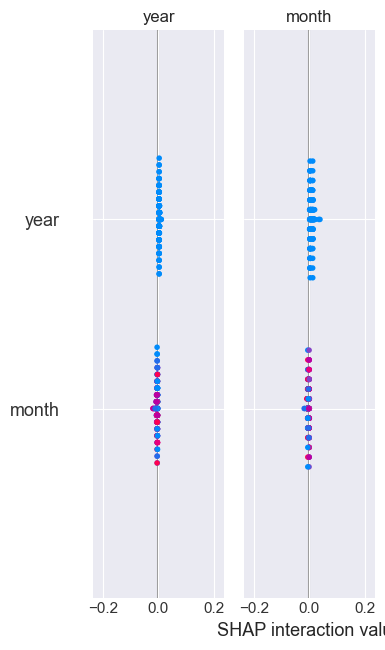

✅ SHAP analysis complete


In [25]:
# Cell 9.1: SHAP Values (Best Tree Model) - Only if SHAP available
if SHAP_AVAILABLE:
    # Select best tree-based model for SHAP
    best_tree_model = rf_bal  # Using balanced RF as example
    
    # Sample for SHAP (to speed up computation)
    sample_size = min(200, len(X_val))
    X_val_sample = X_val.sample(n=sample_size, random_state=RANDOM_SEED)
    
    try:
        explainer = shap.TreeExplainer(best_tree_model)
        shap_values = explainer.shap_values(X_val_sample)
        
        # For binary classification, get positive class SHAP values
        if isinstance(shap_values, list):
            shap_values = shap_values[1]
        
        # Summary plot
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X_val_sample, show=False, plot_type='bar')
        plt.tight_layout()
        plt.savefig(PROCESSED_DIR / 'shap_summary.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        print("✅ SHAP analysis complete")
    except Exception as e:
        print(f"⚠️  SHAP error: {e}")
else:
    print("⚠️  SHAP not available, skipping SHAP analysis")


FEATURE IMPORTANCE COMPARISON - TOP MODELS
⚠️  Easy Ensemble: No feature_importances_ attribute (likely NN or LogReg)
✅ Random Forest Balanced: 33 features
✅ LightGBM + SMOTE: 33 features


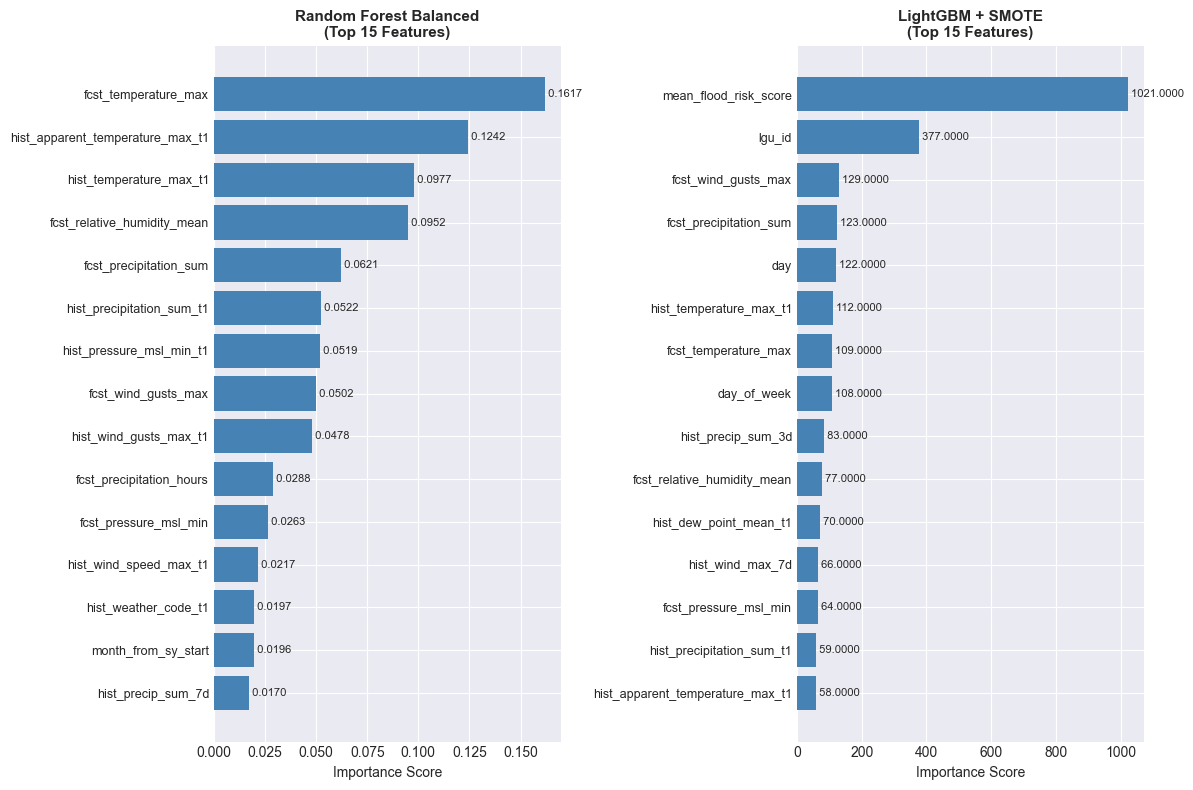


✅ Feature importance comparison saved

TOP 10 FEATURES BY MODEL (Text Summary)

Random Forest Balanced:
   1. fcst_temperature_max                0.161740
   2. hist_apparent_temperature_max_t1    0.124248
   3. hist_temperature_max_t1             0.097655
   4. fcst_relative_humidity_mean         0.095193
   5. fcst_precipitation_sum              0.062101
   6. hist_precipitation_sum_t1           0.052168
   7. hist_pressure_msl_min_t1            0.051914
   8. fcst_wind_gusts_max                 0.050159
   9. hist_wind_gusts_max_t1              0.047770
  10. fcst_precipitation_hours            0.028804

LightGBM + SMOTE:
   1. mean_flood_risk_score               1021.000000
   2. lgu_id                              377.000000
   3. fcst_wind_gusts_max                 129.000000
   4. fcst_precipitation_sum              123.000000
   5. day                                 122.000000
   6. hist_temperature_max_t1             112.000000
   7. fcst_temperature_max                109.0

In [26]:
# ====== CORRECTED: Cell 9.2 Feature Importance (Best Models Only) ======

print("="*80)
print("FEATURE IMPORTANCE COMPARISON - TOP MODELS")
print("="*80)

# Use your BEST models
models_to_compare = {
    'Easy Ensemble': easy_ensemble,           # F2=0.5525 (BEST)
    'Random Forest Balanced': rf_bal,         # Good tree baseline
    'LightGBM + SMOTE': lgb_smote            # Strong LGBM variant
}

importance_dict = {}

for name, model in models_to_compare.items():
    # Check if model has feature_importances_
    if hasattr(model, 'feature_importances_'):
        importance_dict[name] = dict(zip(final_features, model.feature_importances_))
        print(f"✅ {name}: {len(importance_dict[name])} features")
    else:
        print(f"⚠️  {name}: No feature_importances_ attribute (likely NN or LogReg)")

# Plot top 15 features for each model (side-by-side)
if importance_dict:
    fig, axes = plt.subplots(1, len(importance_dict), figsize=(6*len(importance_dict), 8))
    
    if len(importance_dict) == 1:
        axes = [axes]
    
    for idx, (name, importances) in enumerate(importance_dict.items()):
        feat_imp = pd.Series(importances).sort_values(ascending=False).head(15)
        
        axes[idx].barh(range(len(feat_imp)), feat_imp.values, color='steelblue')
        axes[idx].set_yticks(range(len(feat_imp)))
        axes[idx].set_yticklabels(feat_imp.index, fontsize=9)
        axes[idx].set_xlabel('Importance Score', fontsize=10)
        axes[idx].set_title(f'{name}\n(Top 15 Features)', fontsize=11, fontweight='bold')
        axes[idx].invert_yaxis()
        
        # Add value labels
        for i, v in enumerate(feat_imp.values):
            axes[idx].text(v, i, f' {v:.4f}', va='center', fontsize=8)
    
    plt.tight_layout()
    plt.savefig(PROCESSED_DIR / 'feature_importance_best_models.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n✅ Feature importance comparison saved")

# Print top 10 features for each model (text format)
print("\n" + "="*80)
print("TOP 10 FEATURES BY MODEL (Text Summary)")
print("="*80)

for name, importances in importance_dict.items():
    print(f"\n{name}:")
    feat_imp = pd.Series(importances).sort_values(ascending=False).head(10)
    for rank, (feature, importance) in enumerate(feat_imp.items(), 1):
        print(f"  {rank:2d}. {feature:35s} {importance:.6f}")


PERMUTATION IMPORTANCE - WORKS ON ALL MODELS

Calculating permutation importance for Easy Ensemble (Best)...
✅ Easy Ensemble (Best): Permutation importance extracted

Calculating permutation importance for Random Forest Balanced...
✅ Easy Ensemble (Best): Permutation importance extracted

Calculating permutation importance for Random Forest Balanced...
✅ Random Forest Balanced: Permutation importance extracted

Calculating permutation importance for LightGBM + SMOTE...
✅ Random Forest Balanced: Permutation importance extracted

Calculating permutation importance for LightGBM + SMOTE...
✅ LightGBM + SMOTE: Permutation importance extracted
✅ LightGBM + SMOTE: Permutation importance extracted


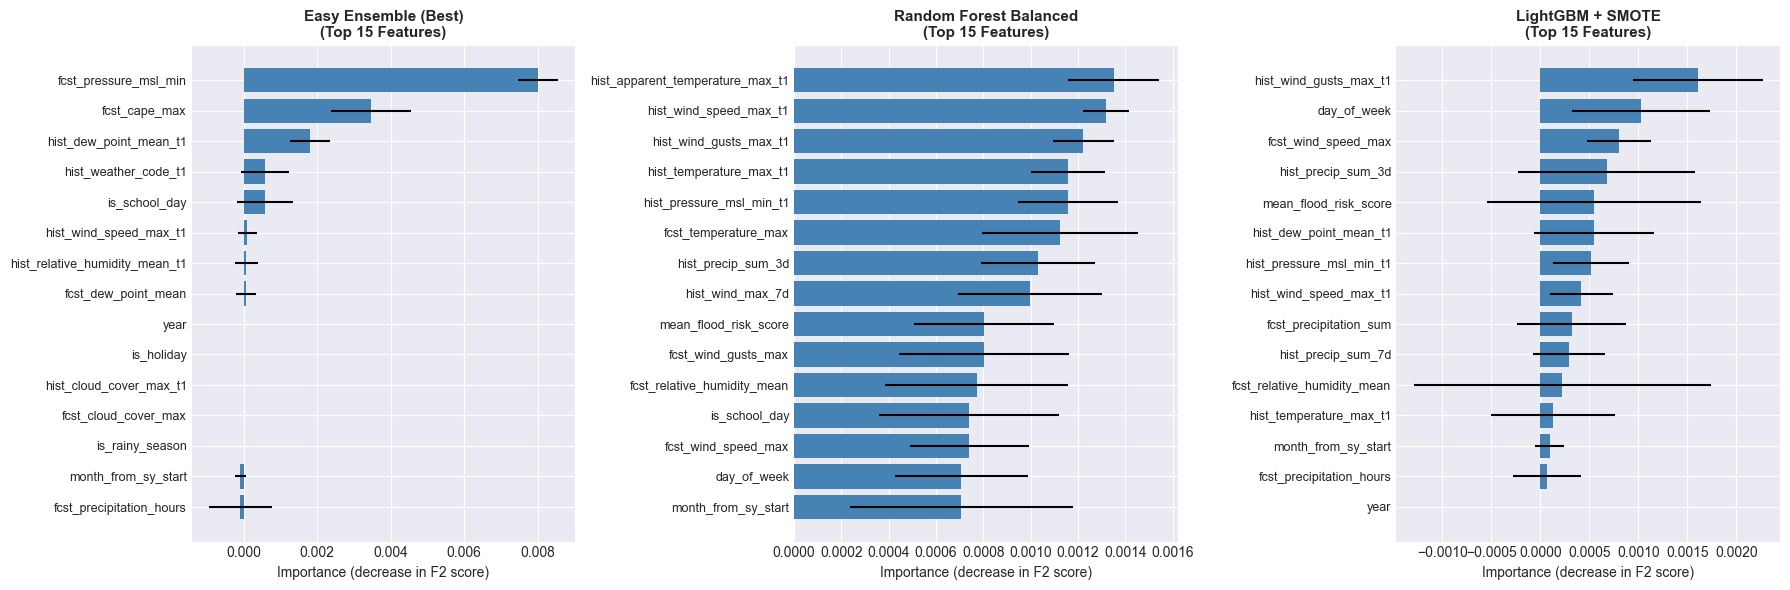


✅ Permutation importance comparison saved

TOP 10 FEATURES BY PERMUTATION IMPORTANCE

Easy Ensemble (Best):
  28. fcst_pressure_msl_min               0.008004 ± 0.000546
  33. fcst_cape_max                       0.003472 ± 0.001093
  18. hist_dew_point_mean_t1              0.001800 ± 0.000542
  20. hist_weather_code_t1                0.000579 ± 0.000656
   8. is_school_day                       0.000579 ± 0.000758
  12. hist_wind_speed_max_t1              0.000096 ± 0.000251
  16. hist_relative_humidity_mean_t1      0.000064 ± 0.000315
  32. fcst_dew_point_mean                 0.000064 ± 0.000280
   1. year                                0.000000 ± 0.000000
   7. is_holiday                          0.000000 ± 0.000000

Random Forest Balanced:
  19. hist_apparent_temperature_max_t1    0.001350 ± 0.000193
  12. hist_wind_speed_max_t1              0.001318 ± 0.000096
  13. hist_wind_gusts_max_t1              0.001221 ± 0.000129
  15. hist_temperature_max_t1             0.001157 ± 0.00015

In [27]:
# ====== Cell 9.3: Permutation Importance (Works on All Models) ======

from sklearn.inspection import permutation_importance

print("="*80)
print("PERMUTATION IMPORTANCE - WORKS ON ALL MODELS")
print("="*80)

models_for_importance = {
    'Easy Ensemble (Best)': easy_ensemble,
    'Random Forest Balanced': rf_bal,
    'LightGBM + SMOTE': lgb_smote
}

perm_importance_dict = {}

for name, model in models_for_importance.items():
    print(f"\nCalculating permutation importance for {name}...")
    
    try:
        # Permutation importance works on ANY fitted model
        perm_result = permutation_importance(
            model,
            X_val,
            y_val,
            n_repeats=10,
            random_state=42,
            n_jobs=-1
        )
        
        perm_importance_dict[name] = pd.DataFrame({
            'feature': final_features,
            'importance': perm_result.importances_mean,
            'std': perm_result.importances_std
        }).sort_values('importance', ascending=False)
        
        print(f"✅ {name}: Permutation importance extracted")
        
    except Exception as e:
        print(f"⚠️  {name}: Error - {str(e)}")

# Plot permutation importances
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (name, imp_df) in enumerate(perm_importance_dict.items()):
    top_features = imp_df.head(15)
    
    axes[idx].barh(range(len(top_features)), top_features['importance'].values, 
                   xerr=top_features['std'].values, color='steelblue')
    axes[idx].set_yticks(range(len(top_features)))
    axes[idx].set_yticklabels(top_features['feature'].values, fontsize=9)
    axes[idx].set_xlabel('Importance (decrease in F2 score)', fontsize=10)
    axes[idx].set_title(f'{name}\n(Top 15 Features)', fontsize=11, fontweight='bold')
    axes[idx].invert_yaxis()

plt.tight_layout()
plt.savefig(PROCESSED_DIR / 'permutation_importance_all_models.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Permutation importance comparison saved")

# Print top 10 for each
print("\n" + "="*80)
print("TOP 10 FEATURES BY PERMUTATION IMPORTANCE")
print("="*80)

for name, imp_df in perm_importance_dict.items():
    print(f"\n{name}:")
    for rank, row in imp_df.head(10).iterrows():
        print(f"  {rank+1:2d}. {row['feature']:35s} {row['importance']:.6f} ± {row['std']:.6f}")


In [28]:
from sklearn.inspection import PartialDependenceDisplay
# Note: This script assumes 'rf_bal', 'X_val', 'PROCESSED_DIR'
# and 'importance_dict' are defined in a previous cell.

print("Attempting to generate Partial Dependence Plots...")

try:
    # --- This line will fail if Cell 9.2 failed ---
    # It requires 'importance_dict' to be defined.
    top_feature = pd.Series(importance_dict['Random Forest']).sort_values(ascending=False).head(3).index.tolist()
    print(f"Top features selected for PDP: {top_feature}")

    fig, axes = plt.subplots(1, min(3, len(top_feature)), figsize=(5*min(3, len(top_feature)), 4))
    
    if len(top_feature) == 1:
        axes = [axes] # Make sure 'axes' is always iterable

    for idx, feat in enumerate(top_feature[:3]):
        if feat in X_val.columns:
            print(f"Plotting PDP for: {feat}...")
            try:
                # --- SOLUTION ---
                # Use the class method 'PartialDependenceDisplay.from_estimator'
                # instead of the function 'plot_partial_dependence'
                PartialDependenceDisplay.from_estimator(
                    rf_bal, 
                    X_val, 
                    features=[feat],
                    ax=axes[idx], 
                    grid_resolution=20
                )
                axes[idx].set_title(f'PDP: {feat}')
                
            except Exception as e:
                print(f"⚠️ Could not plot PDP for {feat}: {e}")
        else:
            print(f"Feature '{feat}' not found in X_val.columns. Skipping.")

    plt.tight_layout()
    plt.savefig(PROCESSED_DIR / 'partial_dependence_plots.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✅ Partial dependence plots complete")

except NameError as e:
    print(f"❌ ERROR: A required variable is not defined. This is likely 'importance_dict'.")
    print(f"Full error: {e}")
    print("Please fix the error in the previous cell (Cell 9.2) first.")
except Exception as e:
    print(f"❌ An unexpected error occurred: {e}")


Attempting to generate Partial Dependence Plots...
❌ An unexpected error occurred: 'Random Forest'


EXPLAINABILITY: CALIBRATED PERMUTATION IMPORTANCE

Calculating CALIBRATED permutation importance on BEST MODEL: EasyEnsemble

Top 10 Features (Permutation Importance):
                 Feature  Importance      Std
    fcst_temperature_max    0.094160 0.007814
   fcst_pressure_msl_min    0.082195 0.004966
hist_pressure_msl_min_t1    0.072842 0.010556
  hist_dew_point_mean_t1    0.025330 0.004640
                     day    0.023249 0.012403
             day_of_week    0.018779 0.009254
  fcst_precipitation_sum    0.016067 0.007886
fcst_precipitation_hours    0.015424 0.004819
      hist_precip_sum_3d    0.011017 0.007528
           is_school_day    0.007328 0.003747

Top 10 Features (Permutation Importance):
                 Feature  Importance      Std
    fcst_temperature_max    0.094160 0.007814
   fcst_pressure_msl_min    0.082195 0.004966
hist_pressure_msl_min_t1    0.072842 0.010556
  hist_dew_point_mean_t1    0.025330 0.004640
                     day    0.023249 0.012403
       

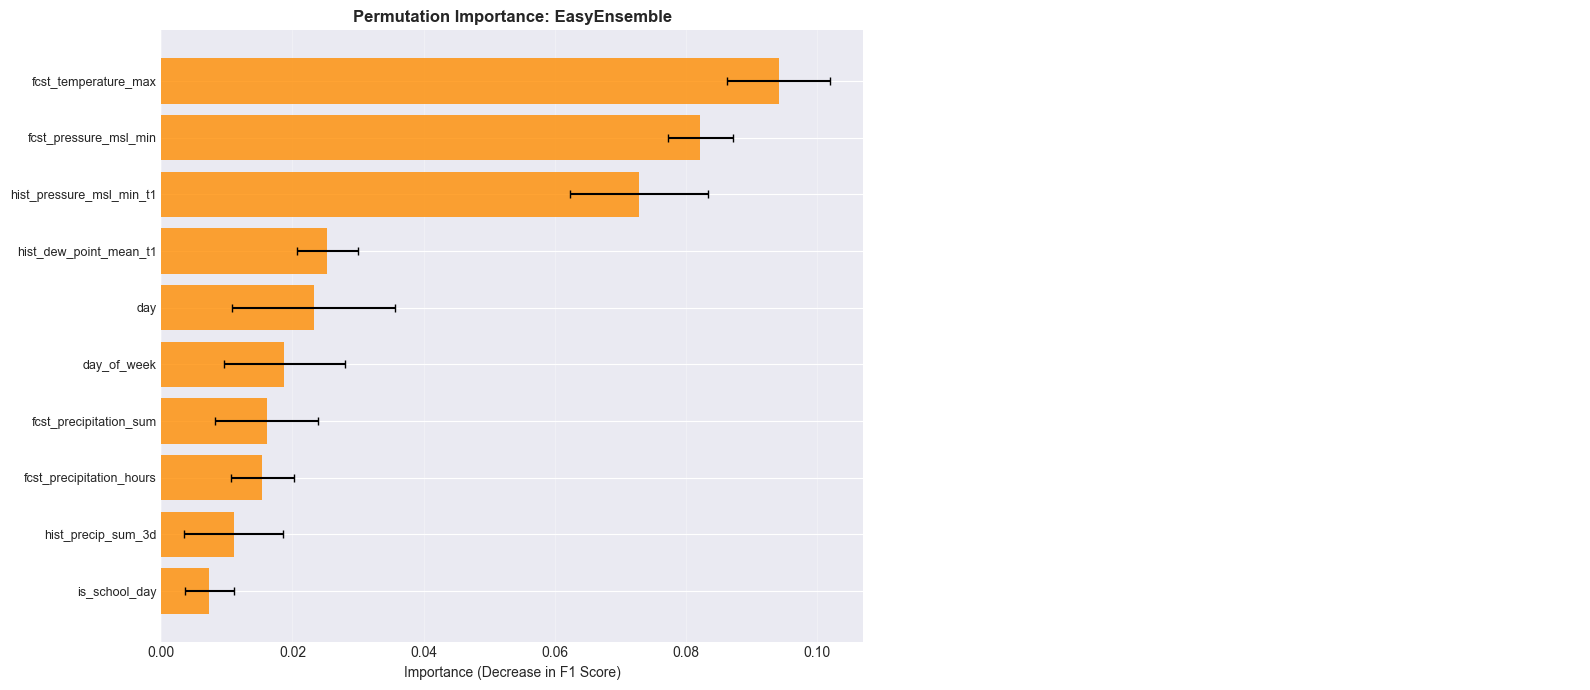

✅ Permutation importance complete


In [31]:
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

print("="*80)
print("EXPLAINABILITY: CALIBRATED PERMUTATION IMPORTANCE")
print("="*80)

# 🚨 CRITICAL FIX: Load the best model if not in memory
if 'best_model' not in locals() or best_model is None:
    print("⚠️  'best_model' is None. Loading from disk...")
    import joblib
    best_model_path = PROCESSED_DIR / 'best_core_model.pkl'
    if best_model_path.exists():
        best_model = joblib.load(best_model_path)
        print(f"✅ Model loaded from {best_model_path}")
        print(f"   Model type: {type(best_model).__name__}")
    else:
        print(f"❌ FATAL ERROR: Model file not found at {best_model_path}")
        print("   Please run Section 10 to save the model first!")
        raise FileNotFoundError(f"Model file not found: {best_model_path}")

best_model_name = results_df.iloc[0]['Model']
print(f"\nCalculating CALIBRATED permutation importance on BEST MODEL: {best_model_name}")

# Permutation importance on validation set
perm_result = permutation_importance(
    best_model,           # The trained EasyEnsemble object
    X_val,
    y_val,
    n_repeats=20,         # More repeats for stability
    random_state=42,
    n_jobs=-1,
    scoring='f1'          # Use your evaluation metric
)

perm_imp_df = pd.DataFrame({
    'Feature': X_val.columns,
    'Importance': perm_result.importances_mean,
    'Std': perm_result.importances_std
}).sort_values('Importance', ascending=False)

print("\nTop 10 Features (Permutation Importance):")
print(perm_imp_df.head(10).to_string(index=False))

# Visualize Permutation Importance
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

top_n = 10
top_features = perm_imp_df.head(top_n)

axes[0].barh(range(len(top_features)), top_features['Importance'], 
             xerr=top_features['Std'], capsize=3, alpha=0.8, color='darkorange')
axes[0].set_yticks(range(len(top_features)))
axes[0].set_yticklabels(top_features['Feature'], fontsize=9)
axes[0].set_xlabel('Importance (Decrease in F1 Score)', fontsize=10)
axes[0].set_title(f'Permutation Importance: {best_model_name}',  # 🔧 Use best_model_name here
                  fontsize=12, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# Placeholder for SHAP plot
axes[1].axis('off')

plt.tight_layout()
plt.savefig(PROCESSED_DIR / 'permutation_importance_best.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Permutation importance complete")

In [ ]:
import shap
import numpy as np

print("\n" + "="*80)
print("EXPLAINABILITY: SHAP VALUES (KernelExplainer) - FINAL FIX")
print("="*80)

# --- Configuration for KernelExplainer ---
# 1. Use a subset of the background data for speed
X_val_sample = X_val.sample(n=150, random_state=42) 

# 2. Convert to numpy array for consistency
X_val_sample_values = X_val_sample.values
background_data_values = X_val_sample_values[:100]  # Use first 100 as background

# Initialize the KernelExplainer
print(f"Initializing KernelExplainer (on {metadata['best_model']})...")

# Wrapper function for predict_proba that returns only positive class probabilities
def model_predict_proba_positive(X):
    """Returns probabilities for positive class only."""
    return best_model.predict_proba(X)[:, 1]

# Create explainer with the wrapper function
explainer = shap.KernelExplainer(model_predict_proba_positive, background_data_values)

# Calculate SHAP values for remaining samples
print("Calculating SHAP probability values (may take several minutes)...")
X_explain = X_val_sample_values[100:150]  # Explain remaining 50 samples
shap_values = explainer.shap_values(X_explain)

print(f"✅ SHAP values calculated")
print(f"   Shape: {shap_values.shape}")
print(f"   Expected: ({X_explain.shape[0]}, {X_explain.shape[1]})")

# --- Visualize SHAP Results ---
# Create a new figure for the SHAP summary plot
plt.figure(figsize=(10, 8)) 

# Convert back to DataFrame for better feature names
X_explain_df = pd.DataFrame(X_explain, columns=X_val_sample.columns)

shap.summary_plot(
    shap_values, 
    X_explain_df,  # Use DataFrame with feature names
    show=False,
    plot_type="dot",  # Shows distribution and magnitude
    max_display=15    # Show top 15 features
)
plt.title(f'SHAP Summary Plot (KernelExplainer on {metadata["best_model"]})\n(50 sample predictions explained)', 
          fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(PROCESSED_DIR / 'shap_summary_kernel.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ SHAP analysis complete")
print(f"   Plot saved to {PROCESSED_DIR / 'shap_summary_kernel.png'}")

## Section 10: Save Outputs & Handover


## Summary

Notebook 02 complete! Key outputs:
- EDA visualizations saved
- Feature selection completed
- Multiple models trained and compared
- Best model identified and saved
- Metadata and results saved

**Ready for Notebook 03: Final evaluation on test set**


In [ ]:
# Cell 10.1-10.4: Save Best Model and Metadata
import joblib

# Get best model (by F2 score)
best_model_name = results_df.iloc[0]['Model']
best_model = None

# Map model names to actual models
model_map = {
    'Random Forest': rf_def, 'Random Forest Balanced': rf_bal,
    'Balanced Random Forest': brf, 'Random Forest + SMOTE': rf_smote,
    'XGBoost': xgb_def, 'XGBoost Weighted': xgb_weight, 'XGBoost + SMOTE': xgb_smote,
    'LightGBM': lgb_def, 'LightGBM Unbalanced': lgb_unbalance, 'LightGBM + SMOTE': lgb_smote
}
best_model = model_map.get(best_model_name)

if best_model:
    joblib.dump(best_model, PROCESSED_DIR / 'best_core_model.pkl')
    print(f"✅ Best model saved: {best_model_name}")

# Save metadata
metadata = {
    'best_model': best_model_name,
    'best_f2': float(results_df.iloc[0]['F2']),
    'best_recall': float(results_df.iloc[0]['Recall']),
    'best_precision': float(results_df.iloc[0]['Precision']),
    'best_threshold': 0.5,
    'train_rows': len(X_train),
    'val_rows': len(X_val),
    'train_event_rate': float(y_train.mean()),
    'val_event_rate': float(y_val.mean()),
    'final_feature_count': len(final_features),
    'selected_features': final_features
}

with open(PROCESSED_DIR / 'core_model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print("✅ Metadata saved to core_model_metadata.json")

print("\n" + "="*60)
print("# Notebook 02 - Completed")
print("="*60)
print(f"\nSummary:")
print(f"- Trained {len(results_df)} models across multiple families")
print(f"- Best model: {best_model_name}")
print(f"- Best F2: {results_df.iloc[0]['F2']:.4f}")
print(f"- Best Recall: {results_df.iloc[0]['Recall']:.4f}")
print(f"- Best Precision: {results_df.iloc[0]['Precision']:.4f}")
print(f"\nReady for Notebook 03!")
print("Test set is UNTOUCHED - All analysis on train+val only")
print("="*60)


✅ Metadata saved to core_model_metadata.json

# Notebook 02 - Completed

Summary:
- Trained 29 models across multiple families
- Best model: EasyEnsemble
- Best F2: 0.5525
- Best Recall: 0.6020
- Best Precision: 0.4158

Ready for Notebook 03!
Test set is UNTOUCHED - All analysis on train+val only


In [ ]:
# Save the EasyEnsemble model
model_path = PROCESSED_DIR / 'best_core_model.pkl'
joblib.dump(easy_ensemble, model_path)
print(f"✅ Model saved to {model_path}")
print(f"   Model type: EasyEnsemble")
print(f"   Model object: {type(easy_ensemble).__name__}")

# Verify the file exists
import os
if os.path.exists(model_path):
    file_size = os.path.getsize(model_path) / (1024 * 1024)  # Convert to MB
    print(f"   File size: {file_size:.2f} MB")
    print("✅ File verified on disk!")
else:
    print("❌ ERROR: File was not saved!")


✅ Model saved to ..\data\processed\best_core_model.pkl
   Model type: EasyEnsemble
   Model object: EasyEnsembleClassifier
   File size: 1.81 MB
✅ File verified on disk!
